In [2]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from pathlib import Path

# 1. Data cleaning 

Purpose: tidy **product_info.csv** into an analysis-ready table.

Main steps: drop noisy columns `cols_to_drop`, remove rows missing `rating` or `ingredients`, normalize category hierarchy (fill secondary/tertiary), parse `highlights` and `ingredients` into lists and counts.

Outputs: **products_cleaned_base.csv**, **highlight_tag_counts.csv**, **ingredient_token_counts.csv**.

In [ ]:
# ----------------------------------------------------
# 1. Load our data
# ----------------------------------------------------

INPUT_PATH = "data/product_info.csv"
OUTPUT_CLEANED_PATH = "data/products_cleaned_base.csv"
OUTPUT_HIGHLIGHT_COUNTS = "data/highlight_tag_counts.csv"
OUTPUT_INGREDIENT_COUNTS = "data/ingredient_token_counts.csv"

df = pd.read_csv(INPUT_PATH)

# ----------------------------------------------------
# 2. Drop unwanted columns
# ----------------------------------------------------
cols_to_drop = [
    "size",
    "variation_type",
    "variation_value",
    "variation_desc",
    "value_price_usd",
    "sale_price_usd",
    "child_max_price",
    "child_min_price",
]

df = df.drop(columns=cols_to_drop, errors="ignore")

# ----------------------------------------------------
# 3. Drop rows with NaN in rating or ingredients
# ----------------------------------------------------
df = df[df["rating"].notna()]
df = df[df["ingredients"].notna()]

# ----------------------------------------------------
# 4. Clean category hierarchy: primary / secondary / tertiary
# ----------------------------------------------------

def fill_secondary(row):
    sec = row.get("secondary_category")
    if pd.isna(sec):
        prim = row.get("primary_category", "Unknown")
        return f"{prim} General"
    return sec

df["secondary_category"] = df.apply(fill_secondary, axis=1)

# Ttreat NaNs as "General"
if "tertiary_category" in df.columns:
    df["tertiary_category"] = df["tertiary_category"].fillna("General")

# ----------------------------------------------------
# 5. Parse 'highlights' column and prepare tag selection
# ----------------------------------------------------
def parse_list_string(x):
    """
    Safely parse a string that looks like a Python list, e.g.
    "['Vegan', 'Matte Finish']" -> ['Vegan', 'Matte Finish'].
    If NaN or parsing fails, return [].
    """
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return parsed
        else:
            return []
    except Exception:
        
        return []

# New column with parsed highlights as list
if "highlights" in df.columns:
    df["highlights_list"] = df["highlights"].apply(parse_list_string)
else:
    df["highlights_list"] = [[] for _ in range(len(df))]

# Count all highlight tags
all_highlight_tags = [
    tag.strip()
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str)
]

highlight_counter = Counter(all_highlight_tags)


highlight_counts_df = (
    pd.DataFrame(
        [{"tag": tag, "count": count} for tag, count in highlight_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

highlight_counts_df.to_csv(OUTPUT_HIGHLIGHT_COUNTS, index=False)
print(f"Saved highlight tag counts to: {OUTPUT_HIGHLIGHT_COUNTS}")
print(highlight_counts_df.head(15))


df["n_highlights"] = df["highlights_list"].apply(len)

# ----------------------------------------------------
# 6. Parse 'ingredients' and data-driven refinement
# ----------------------------------------------------

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

# join list and lowercase
def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    # join with commas for separation
    text = ", ".join([str(x) for x in ing_list])
    return text.lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)


ingredient_tokens = []

for text in df["ingredients_text"]:
    if not text:
        continue
   
    parts = text.split(",")
    for p in parts:
        token = p.strip()
        if token:
            ingredient_tokens.append(token)

ingredient_counter = Counter(ingredient_tokens)

# Choose top 200
TOP_N_INGREDIENTS = 200
top_ingredients = ingredient_counter.most_common(TOP_N_INGREDIENTS)

ingredient_counts_df = pd.DataFrame(
    [{"ingredient_token": ing, "count": cnt} for ing, cnt in top_ingredients]
).sort_values("count", ascending=False)

ingredient_counts_df.to_csv(OUTPUT_INGREDIENT_COUNTS, index=False)
print(f"Saved ingredient token counts to: {OUTPUT_INGREDIENT_COUNTS}")
print(ingredient_counts_df.head(15))

# ----------------------------------------------------
# 7. Save base cleaned dataset
# ----------------------------------------------------
df.to_csv(OUTPUT_CLEANED_PATH, index=False)
print(f"Saved cleaned dataset (with parsed highlights/ingredients) to: {OUTPUT_CLEANED_PATH}")


Saved highlight tag counts to: data/highlight_tag_counts.csv
                                  tag  count
0                               Vegan   2365
1                        Cruelty-Free   1574
2                    Clean at Sephora   1438
3                    Without Parabens   1282
4                   Good for: Dryness   1119
5                           Hydrating   1100
6   Good for: Dullness/Uneven Texture    856
7         Without Sulfates SLS & SLES    727
8                        Long-wearing    686
9             Clean + Planet Positive    658
10                     All Hair Types    632
11               Good for: Anti-Aging    585
12                    Hyaluronic Acid    560
13                 Without Phthalates    479
14                     Fragrance Free    477
Saved ingredient token counts to: data/ingredient_token_counts.csv
                ingredient_token  count
0                       glycerin   4087
1                 phenoxyethanol   3802
2                caprylyl glycol

In [2]:
df = pd.read_csv("data/products_cleaned_base.csv")
from collections import Counter
def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["highlights_list"] = df["highlights"].apply(parse_list_string)

# Pick enough tags to cover ~80% of highlight mentions but keep the set manageable (~20-30 tags)
tag_counter = Counter(
    tag
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str) and tag.strip()
 )
total_mentions = sum(tag_counter.values()) or 1
coverage_target = 0.8
max_tags = 30
min_tags = 20
selected_tags = []
running_total = 0
for tag, count in tag_counter.most_common():
    running_total += count
    selected_tags.append(tag)
    if len(selected_tags) >= min_tags and (running_total / total_mentions) >= coverage_target:
        break
selected_tags = selected_tags[:max_tags]

print(f"Selected {len(selected_tags)} highlight tags covering {running_total / total_mentions:.1%} of mentions")

for tag in selected_tags:
    col_name = "tag_" + tag.lower().replace(" ", "_").replace("/", "_").replace(":", "").replace(",", "").replace("&", "and")
    df[col_name] = df["highlights_list"].apply(lambda tags: int(tag in tags))

df["n_highlights"] = df["highlights_list"].apply(len)

Selected 30 highlight tags covering 80.2% of mentions


In [3]:
def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    return ", ".join([str(x) for x in ing_list]).lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)

isel = pd.read_csv("data/ingredient_features_selected.csv", sep=";")

group_to_tokens = {}
for _, row in isel.iterrows():
    group = row["group_name"]
    token = str(row["token"]).lower()
    group_to_tokens.setdefault(group, []).append(token)

for group_name, tokens in group_to_tokens.items():
    df[group_name] = df["ingredients_text"].apply(
        lambda txt: int(any(tok in txt for tok in tokens))
    )

df["n_ingredients"] = df["ingredients_text"].apply(
    lambda txt: len([p for p in txt.split(",") if p.strip()])
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 72 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   product_id                            7322 non-null   object 
 1   product_name                          7322 non-null   object 
 2   brand_id                              7322 non-null   int64  
 3   brand_name                            7322 non-null   object 
 4   loves_count                           7322 non-null   int64  
 5   rating                                7322 non-null   float64
 6   reviews                               7322 non-null   float64
 7   ingredients                           7322 non-null   object 
 8   price_usd                             7322 non-null   float64
 9   limited_edition                       7322 non-null   int64  
 10  new                                   7322 non-null   int64  
 11  online_only      

In [4]:
df.to_csv("data/products_final.csv", index=False)

# 2. Exploratory Data Analysis
We structure the EDA in themed chunks: first a dataset snapshot, then category/assortment diagnostics, followed by price + engagement distributions, price-tier benchmarking, correlation checks, and finally the engineered features that feed the model.

## 2.1 Dataset snapshot & schema check

In [3]:
DATA_PATH = "data/products_final.csv" 
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (7322, 83)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,ingredients,price_usd,limited_edition,...,log_loves,log_reviews,reviews_per_love,price_bucket,scaled_rating,loves_count_norm,scaled_rating_norm,reviews_norm,popularity_score,popularity_proxy
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,0,...,8.751633,2.484907,0.001740,"(25.0, 35.0]",0.001880,0.004511,0.000444,0.000470,0.0017,0
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,8.250098,2.639057,0.003396,"(58.0, 449.0]",0.002537,0.002731,0.000603,0.000564,0.0013,0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,8.087640,2.833213,0.004917,"(58.0, 449.0]",0.003195,0.002322,0.000762,0.000705,0.0012,0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,8.012681,3.091042,0.006956,"(58.0, 449.0]",0.004417,0.002154,0.001058,0.000940,0.0014,0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,7.898040,2.639057,0.004829,"(58.0, 449.0]",0.001974,0.001921,0.000466,0.000564,0.0010,0


### Numeric coverage snapshot
Key numeric fields to monitor: price, engagement (reviews/loves), and engineered counts.

In [4]:
num_cols = ["price_usd", "loves_count", "rating", "reviews", "n_highlights", "n_ingredients"]
summary_stats = df[num_cols].describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
price_usd,7322.0,50.520610,47.669602,3.0,25.000000,35.00000,58.00000,449.0
loves_count,7322.0,31479.851543,68960.425831,0.0,4285.750000,10849.50000,29041.25000,1401068.0
rating,7322.0,4.199126,0.495827,1.0,3.995875,4.28885,4.52475,5.0
reviews,7322.0,478.301147,1125.133923,1.0,31.000000,144.00000,453.00000,21281.0
n_highlights,7322.0,3.749659,2.407591,0.0,2.000000,5.00000,6.00000,9.0
n_ingredients,7322.0,35.048211,34.133443,1.0,19.000000,28.00000,40.00000,720.0


## 2.2 Category & assortment depth

In [5]:
product_id_col = "product_id" if "product_id" in df.columns else "product_name"
category_summary = (
    df.groupby("primary_category")
      .agg(
          products=(product_id_col, "nunique"),
          avg_price=("price_usd", "mean"),
          avg_loves=("loves_count", "mean"),
          avg_reviews=("reviews", "mean"),
          avg_rating=("rating", "mean"),
      )
      .sort_values("products", ascending=False)
      .head(10)
      .round(2)
)
category_summary

,products,avg_price,avg_loves,avg_reviews,avg_rating
primary_category,,,,,
Skincare,2224,58.40,28553.74,480.47,4.23
Makeup,1999,33.23,58668.89,747.16,4.14
Hair,1232,35.18,14892.55,276.18,4.22
Fragrance,1186,91.21,14494.89,292.70,4.25
Bath & Body,364,40.85,17803.96,210.18,4.19
Mini Size,257,20.51,28761.14,668.09,4.00
Men,58,32.97,4997.52,73.95,4.50
Tools & Brushes,2,25.00,6086.50,41.50,4.20


### Brand footprint & pricing leaders
We highlight which brands dominate assortment volume and which command the highest average price.

#### Top brands by product count

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/1784458386.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_count.values, y=brand_count.index, palette="Blues_r")


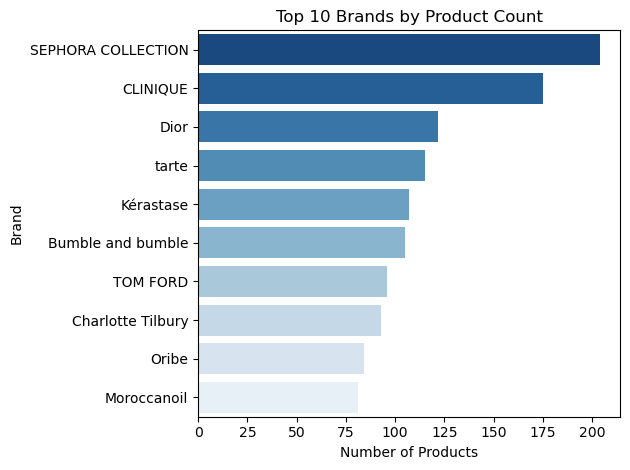

In [6]:
brand_count = df['brand_name'].value_counts().nlargest(10)
sns.barplot(x=brand_count.values, y=brand_count.index, palette="Blues_r")
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Number of Products')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

#### Premium positioning by brand

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/891791911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


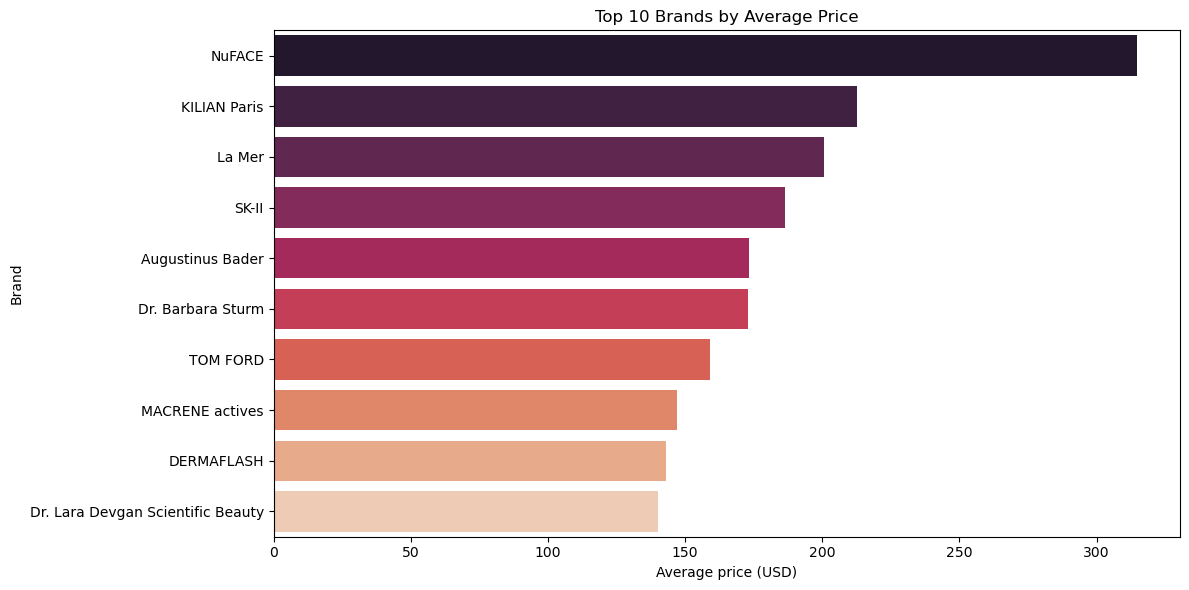

brand_name
NuFACE                               314.636364
KILIAN Paris                         212.826087
La Mer                               200.526316
SK-II                                186.437500
Augustinus Bader                     173.368421
Dr. Barbara Sturm                    172.804878
TOM FORD                             159.114583
MACRENE actives                      147.000000
DERMAFLASH                           143.000000
Dr. Lara Devgan Scientific Beauty    140.000000
Name: price_usd, dtype: float64

In [7]:
brand_price = (
    df.groupby("brand_name")["price_usd"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=brand_price.values,
    y=brand_price.index,
    order=brand_price.index,
    palette="rocket"
)
plt.title("Top 10 Brands by Average Price")
plt.xlabel("Average price (USD)")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

brand_price

### Assortment depth via child counts
Products can have multiple shade/size variants captured in `child_count`. Understanding its distribution highlights where the catalog relies on deep variant coverage versus single-SKU listings.

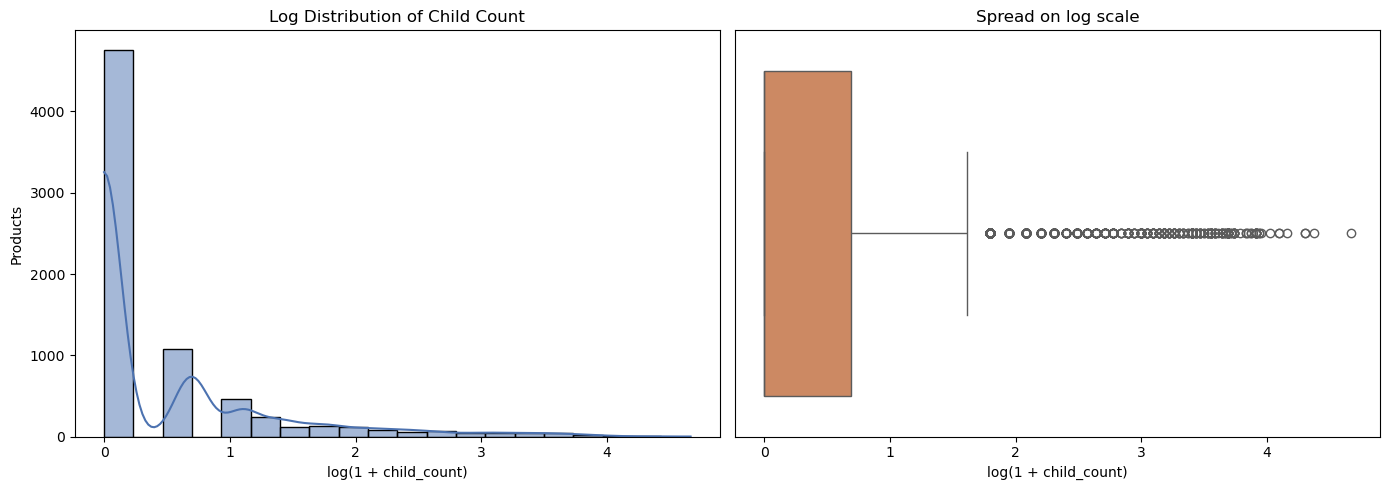

In [8]:
child_data = df["child_count"].dropna()
if child_data.empty:
    print("No child_count information available.")
else:
    child_log = np.log1p(child_data)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(child_log, bins=20, kde=True, ax=axes[0], color="#4c72b0")
    axes[0].set_title("Log Distribution of Child Count")
    axes[0].set_xlabel("log(1 + child_count)")
    axes[0].set_ylabel("Products")

    sns.boxplot(x=child_log, ax=axes[1], color="#dd8452")
    axes[1].set_title("Spread on log scale")
    axes[1].set_xlabel("log(1 + child_count)")
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

### Channel mix: online-only vs omnichannel
`online_only` flags Sephora-exclusive digital items. Visualizing it reveals how much of the range depends on physical inventory.

online_only
Omnichannel    79.9%
Online only    20.1%
Name: count, dtype: object

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/2185617988.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=online_share.index, y=online_share.values, palette=["#55a868", "#c44e52"])


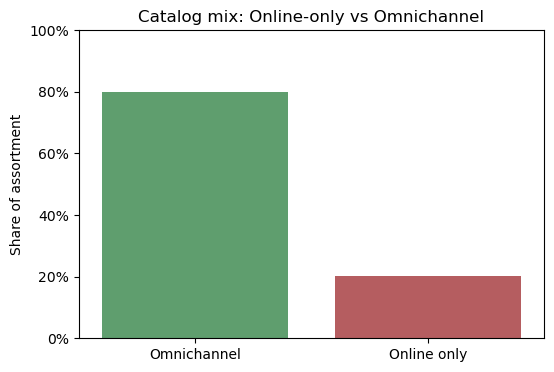

In [9]:
if "online_only" not in df.columns:
    print("online_only column missing in dataset.")
else:
    online_counts = df["online_only"].value_counts(dropna=True)
    online_share = (online_counts / online_counts.sum()).rename({0: "Omnichannel", 1: "Online only"})
    display(online_share.map(lambda x: f"{x:.1%}"))

    plt.figure(figsize=(6, 4))
    sns.barplot(x=online_share.index, y=online_share.values, palette=["#55a868", "#c44e52"])
    plt.title("Catalog mix: Online-only vs Omnichannel")
    plt.ylabel("Share of assortment")
    plt.xlabel("")
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
    plt.show()

## 2.3 Price & engagement distributions
We now explore how price, ratings, loves, and reviews distribute across the portfolio, calling out skew/outliers before layering on correlations.

### Boxplot view of skew/outliers
The core KPIs (price, rating, loves) show heavy tails; boxplots summarize their spread before we inspect full distributions.

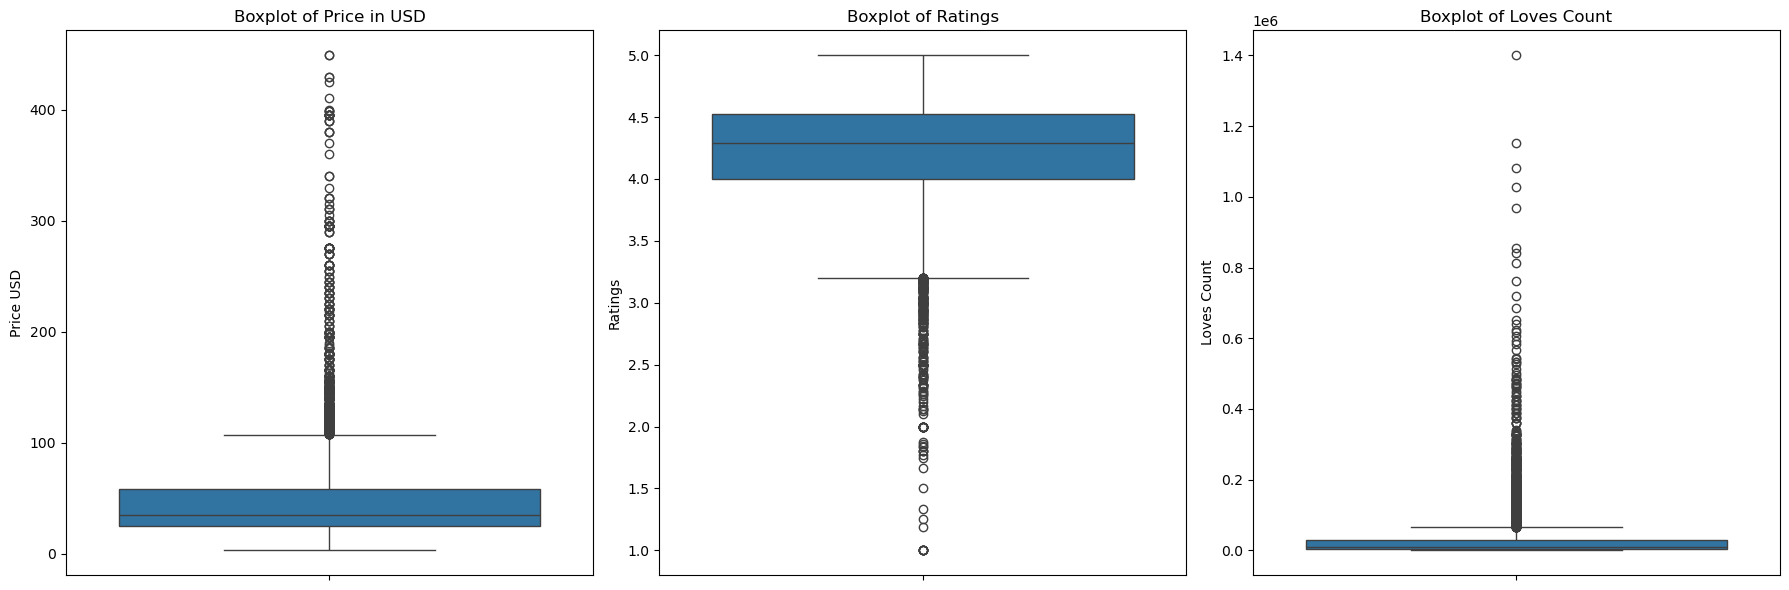

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for 'price_usd'
sns.boxplot(y=df['price_usd'], ax=axes[0])
axes[0].set_title('Boxplot of Price in USD')
axes[0].set_ylabel('Price USD')

# Boxplot for 'rating'
sns.boxplot(y=df['rating'], ax=axes[1])
axes[1].set_title('Boxplot of Ratings')
axes[1].set_ylabel('Ratings')

# Boxplot for 'loves_count'
sns.boxplot(y=df['loves_count'], ax=axes[2])
axes[2].set_title('Boxplot of Loves Count')
axes[2].set_ylabel('Loves Count')

# Display the plots
plt.tight_layout()
plt.show()


### Distribution histograms
Visualize how price, ratings, and loves spread across all SKUs to understand skewness and tails.

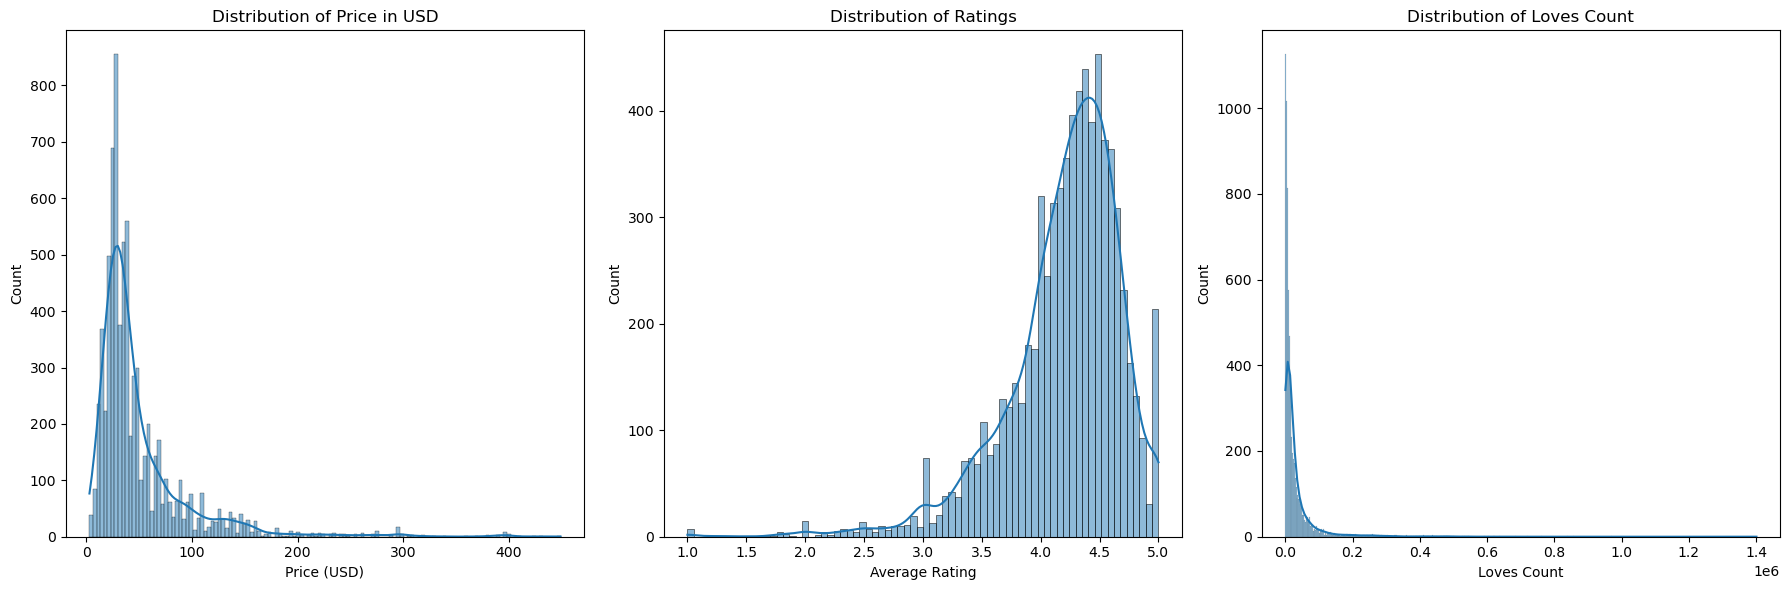

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df['price_usd'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price in USD')
axes[0].set_xlabel('Price (USD)')

sns.histplot(df['rating'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Ratings')
axes[1].set_xlabel('Average Rating')

sns.histplot(df['loves_count'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Loves Count')
axes[2].set_xlabel('Loves Count')

plt.tight_layout()
plt.show()

### Price vs. engagement scattercuts
Price elasticity shows up when plotting price against loves and ratings; we include both cuts for completeness.

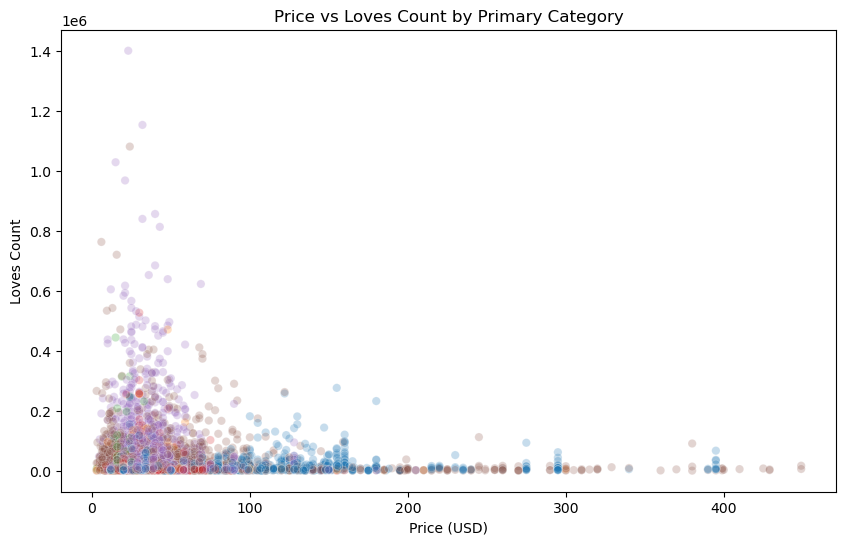

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="price_usd",
    y="loves_count",
    hue="primary_category",
    alpha=0.25,
    legend=False
)
plt.title("Price vs Loves Count by Primary Category")
plt.xlabel("Price (USD)")
plt.ylabel("Loves Count")
plt.show()

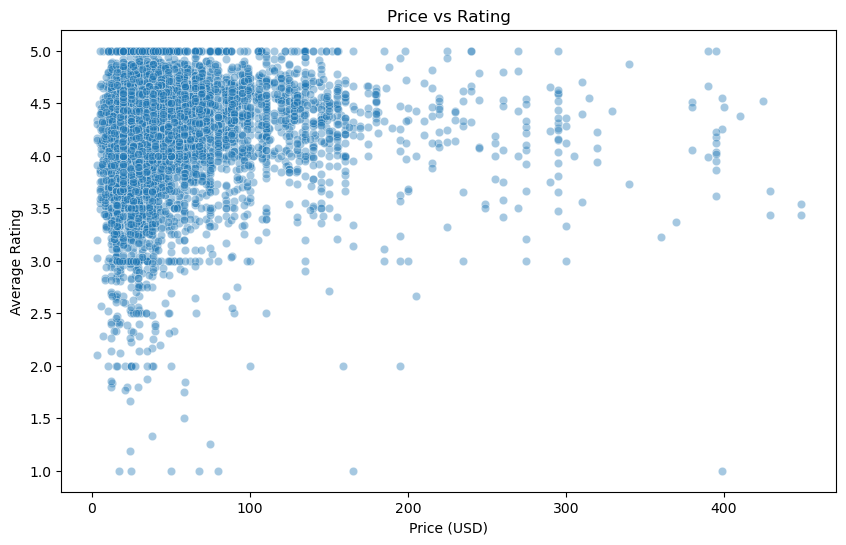

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price_usd', y='rating', data=df, alpha=0.4)
plt.title('Price vs Rating')
plt.xlabel('Price (USD)')
plt.ylabel('Average Rating')
plt.show()

## 2.4 Price tiers vs engagement
Segment products into spend tiers to see if premium positioning correlates with customer actions.

In [14]:
price_labels = ["Budget", "Mass", "Prestige", "Luxury"]
price_bins = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")
if price_bins.dtype == "O" or len(price_bins.cat.categories) < len(price_labels):
    price_labels = price_labels[:len(price_bins.cat.categories)]
price_segment_col = price_bins.cat.rename_categories(price_labels)

df["price_segment"] = price_segment_col
price_segment_summary = (
    df.groupby("price_segment")
    .agg(
        products=("product_name", "count"),
        avg_loves=("loves_count", "mean"),
        avg_reviews=("reviews", "mean"),
        avg_rating=("rating", "mean"),
        median_price=("price_usd", "median")
    )
    .round(2)
)
price_segment_summary

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/2442587172.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("price_segment")


,products,avg_loves,avg_reviews,avg_rating,median_price
price_segment,,,,,
Budget,1909,38585.40,533.07,4.07,20.0
Mass,1811,32618.54,495.94,4.19,30.0
Prestige,1826,34828.56,533.15,4.25,44.0
Luxury,1776,19238.08,345.05,4.29,90.0


## 2.5 Engagement correlations
Quantify how the main behavioral signals align with one another before defining the final business target.

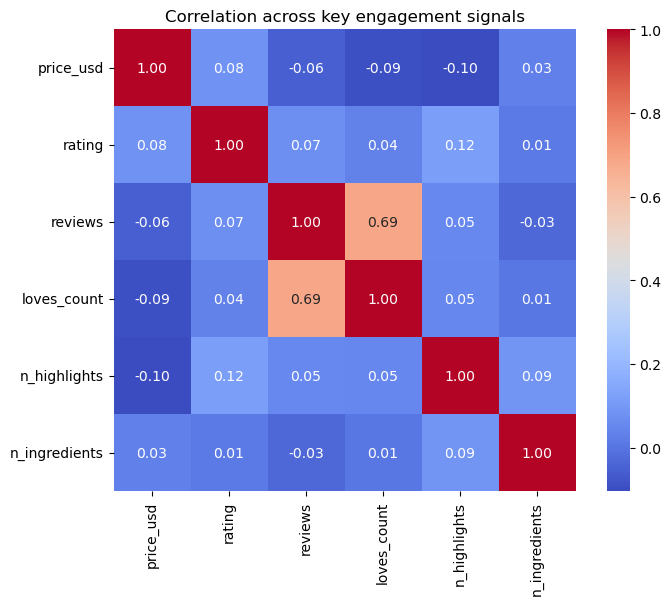

,price_usd,rating,reviews,loves_count,n_highlights,n_ingredients
price_usd,1.000000,0.079010,-0.056744,-0.092535,-0.104400,0.029547
rating,0.079010,1.000000,0.071651,0.037934,0.117010,0.014859
reviews,-0.056744,0.071651,1.000000,0.685993,0.053494,-0.034619
loves_count,-0.092535,0.037934,0.685993,1.000000,0.047820,0.005437
n_highlights,-0.104400,0.117010,0.053494,0.047820,1.000000,0.088142
n_ingredients,0.029547,0.014859,-0.034619,0.005437,0.088142,1.000000


In [15]:
engagement_cols = [
    "price_usd",
    "rating",
    "reviews",
    "loves_count",
    "n_highlights",
    "n_ingredients"
]
existing_cols = [c for c in engagement_cols if c in df.columns]
corr = df[existing_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation across key engagement signals")
plt.show()

corr

## 2.6 Feature engineering hooks
Create reusable metrics that will later help define the engagement target and power the ML models.

In [16]:
df["log_loves"] = np.log1p(df["loves_count"])
df["log_reviews"] = np.log1p(df["reviews"])
df["reviews_per_love"] = df["reviews"] / (df["loves_count"] + 1)
df["price_bucket"] = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")

feature_preview = df[["price_usd", "price_bucket", "log_loves", "log_reviews", "reviews_per_love"]].head()
feature_preview

,price_usd,price_bucket,log_loves,log_reviews,reviews_per_love
0,35.0,"(25.0, 35.0]",8.751633,2.484907,0.001740
1,195.0,"(58.0, 449.0]",8.250098,2.639057,0.003396
2,195.0,"(58.0, 449.0]",8.087640,2.833213,0.004917
3,195.0,"(58.0, 449.0]",8.012681,3.091042,0.006956
4,195.0,"(58.0, 449.0]",7.898040,2.639057,0.004829


## 2.7 Additional feature distributions

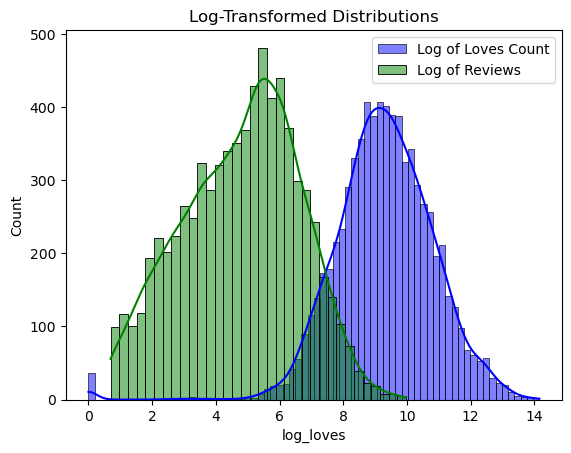

In [17]:
sns.histplot(df['log_loves'], kde=True, color='blue', label='Log of Loves Count')
sns.histplot(df['log_reviews'], kde=True, color='green', label='Log of Reviews')
plt.legend()
plt.title('Log-Transformed Distributions')
plt.show()

# 3. Popularity Score 

First we need to do some scaling for the rating , as some products might have a super small amount of reviews and still have a rating of 5 

In [18]:
df['scaled_rating'] = df['rating'] * (df['reviews'] / df['reviews'].max())

Now we define the popularity score as a normalized blend of the three engagement signals (`loves_count`, review-adjusted rating, and `reviews`). Rather than hand-picking weights, we let the data drive the importance: features with higher variability (after scaling) get slightly more influence because they help discriminate products.

We used the standard deviations of each normalized feature in order to assess the variation that each signal has to create the feature weights that will be applied to define the popularity score.

In [19]:
engagement_cols = ["loves_count", "scaled_rating", "reviews"]
scaler = MinMaxScaler()
norm_col_names = [f"{col}_norm" for col in engagement_cols]
df[norm_col_names] = scaler.fit_transform(df[engagement_cols])

feature_stds = df[norm_col_names].std()
feature_weights = (feature_stds / feature_stds.sum()).to_dict()
feature_weights

{'loves_count_norm': 0.31329909644843823,
 'scaled_rating_norm': 0.3501498014160312,
 'reviews_norm': 0.3365511021355307}

Also, we will apply Min-Max scaling to each individual feature before combining them into the popularity score. This way, the popularity score will naturally be within a bounded range.

In [20]:
df['popularity_score'] = 0
for col_norm in norm_col_names:
    weight = feature_weights.get(col_norm, 0)
    df['popularity_score'] += weight * df[col_norm]

df['popularity_score'] = df['popularity_score'].round(4)
df[['popularity_score'] + norm_col_names].head()

,popularity_score,loves_count_norm,scaled_rating_norm,reviews_norm
0,0.0017,0.004511,0.000444,0.000470
1,0.0013,0.002731,0.000603,0.000564
2,0.0012,0.002322,0.000762,0.000705
3,0.0014,0.002154,0.001058,0.000940
4,0.0010,0.001921,0.000466,0.000564


## 3.1 Binary proxy label for early modeling
Use the current popularity score to build a temporary binary label for EDA/feature selection. We flag the **top 30%** (70th percentile and above) because Sephora typically focuses on a manageable slice of hero products; this keeps the positive class big enough for modeling but still highlights the standouts.

In [21]:
# Top 30% (70th percentile) treated as "popular" for exploratory work
PROXY_PERCENTILE = 0.70
proxy_threshold = df['popularity_score'].quantile(PROXY_PERCENTILE)
df['popularity_proxy'] = (df['popularity_score'] >= proxy_threshold).astype(int)

print(f"Proxy threshold ({int((1-PROXY_PERCENTILE)*100)}% most-popular): {proxy_threshold:.3f}")
print(df['popularity_proxy'].value_counts(normalize=True).rename('share'))

Proxy threshold (30% most-popular): 0.018
popularity_proxy
0    0.699809
1    0.300191
Name: share, dtype: float64


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/1854809614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])


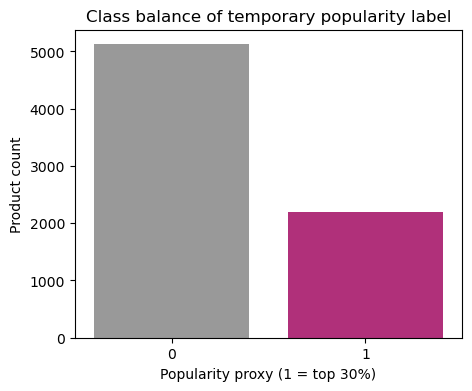

In [22]:
plt.figure(figsize=(5, 4))
sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])
plt.title('Class balance of temporary popularity label')
plt.xlabel('Popularity proxy (1 = top 30%)')
plt.ylabel('Product count')
plt.show()

## 3.2 Feature behavior vs popularity proxy

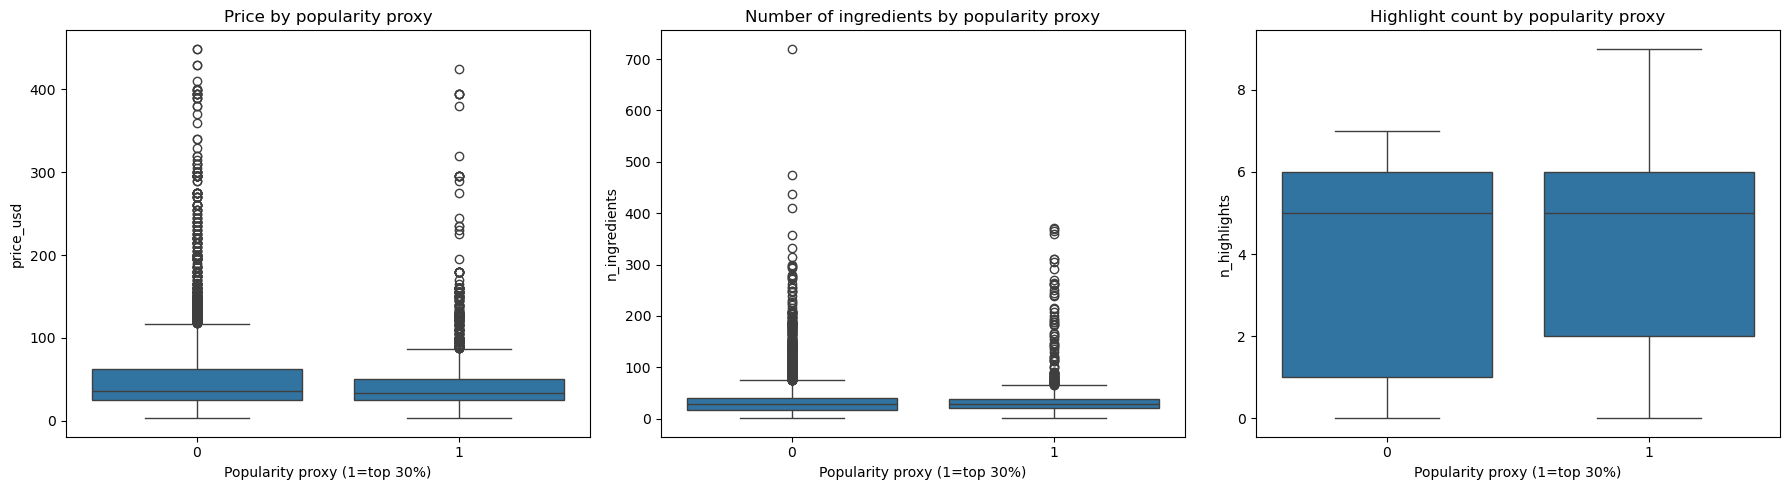

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='popularity_proxy', y='price_usd', data=df, ax=axes[0])
axes[0].set_title('Price by popularity proxy')
sns.boxplot(x='popularity_proxy', y='n_ingredients', data=df, ax=axes[1])
axes[1].set_title('Number of ingredients by popularity proxy')
sns.boxplot(x='popularity_proxy', y='n_highlights', data=df, ax=axes[2])
axes[2].set_title('Highlight count by popularity proxy')
for ax in axes:
    ax.set_xlabel('Popularity proxy (1=top 30%)')
plt.tight_layout()
plt.show()

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/3426141704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


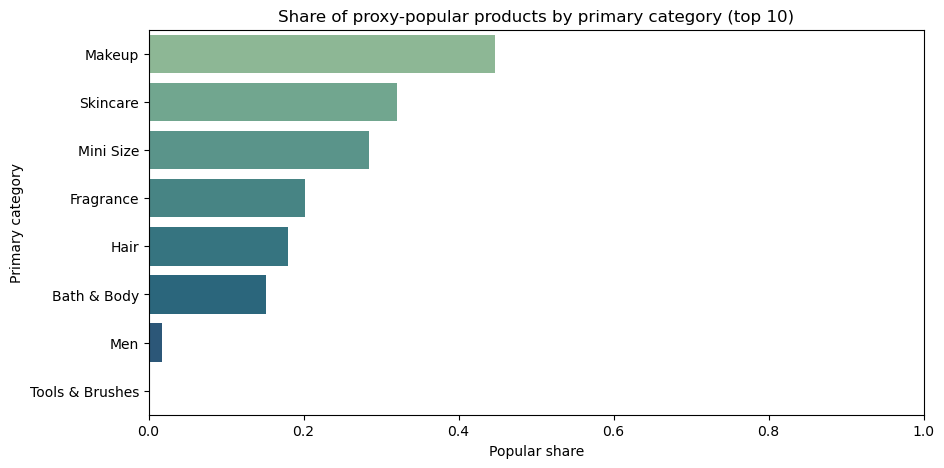

,popular_share,products
primary_category,,
Makeup,0.447224,1999
Skincare,0.321043,2224
Mini Size,0.284047,257
Fragrance,0.201518,1186
Hair,0.180195,1232
Bath & Body,0.151099,364
Men,0.017241,58
Tools & Brushes,0.000000,2


In [24]:
popularity_by_category = (
    df.groupby('primary_category')['popularity_proxy']
      .agg(popular_share='mean', products='count')
      .sort_values('popular_share', ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    y=popularity_by_category.index,
    x=popularity_by_category['popular_share'],
    palette='crest'
)
plt.title('Share of proxy-popular products by primary category (top 10)')
plt.xlabel('Popular share')
plt.ylabel('Primary category')
plt.xlim(0, 1)
plt.show()

popularity_by_category

## 3.3 Highlight & ingredient drivers

Here we are evaluating the uplift in the popularity score that each tagged highlight and each family of ingredients has in average for the products flagged as popular in the popularity_proxy field defined above.

In [25]:
def canonicalize_tag(tag: str) -> str:
    return (
        "tag_"
        + tag.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace(":", "")
        .replace(",", "")
        .replace("&", "and")
    )

# Use existing tag_* columns 
highlight_cols = [col for col in df.columns if col.startswith("tag_")]

highlight_effect_df = pd.DataFrame()
highlight_category_effect_df = pd.DataFrame()

def compute_binary_uplift(frame: pd.DataFrame, columns: list[str], label_name: str) -> pd.DataFrame:
    rows = []
    for col in columns:
        if col not in frame.columns or frame[col].nunique() < 2:
            continue
        means = frame.groupby(col)["popularity_score"].mean()
        avg_with = means.get(1, np.nan)
        avg_without = means.get(0, np.nan)
        if pd.isna(avg_with) or pd.isna(avg_without) or avg_without == 0:
            uplift_pct = np.nan
        else:
            uplift_pct = ((avg_with - avg_without) / avg_without) * 100
        rows.append({
            label_name: col,
            "share": round(frame[col].mean(), 3),
            "avg_popularity_with": avg_with,
            "avg_popularity_without": avg_without,
            "uplift_pct": round(uplift_pct, 2) if pd.notna(uplift_pct) else np.nan,
        })
    return pd.DataFrame(rows)

if not highlight_cols:
    print("Highlight feature columns not found. Make sure the highlight dummy columns were created earlier in the notebook.")
else:
    highlight_effect_df = (
        compute_binary_uplift(df, highlight_cols, "feature")
        .sort_values("uplift_pct", ascending=False)
        .head(10)
    )

    if "primary_category" not in df.columns:
        print("primary_category column not available; skipping category-level highlight uplift.")
    else:
        category_tables = []
        for category, subset in df.groupby("primary_category"):
            cat_table = compute_binary_uplift(subset, highlight_cols, "feature")
            if cat_table.empty:
                continue
            cat_top = cat_table.sort_values("uplift_pct", ascending=False).head(10)
            cat_top.insert(0, "primary_category", category)
            category_tables.append(cat_top)
        if category_tables:
            highlight_category_effect_df = pd.concat(category_tables, ignore_index=True)

print("Overall highlight drivers (top 10)")
display(highlight_effect_df)
print("\nTop highlight drivers per primary_category (top 10 per category)")
display(highlight_category_effect_df)

Overall highlight drivers (top 10)


,feature,share,avg_popularity_with,avg_popularity_without,uplift_pct
8,tag_long-wearing,0.094,0.046806,0.020255,131.08
23,tag_natural_finish,0.046,0.044522,0.021695,105.21
16,tag_matte_finish,0.055,0.040224,0.021727,85.13
21,tag_best_for_oily_combo_normal_skin,0.050,0.036275,0.022031,64.66
17,tag_good_for_pores,0.054,0.030047,0.022324,34.59
3,tag_without_parabens,0.175,0.024717,0.022324,10.72
24,tag_without_silicones,0.044,0.023941,0.022687,5.53
14,tag_fragrance_free,0.065,0.023542,0.022687,3.77
15,tag_best_for_dry_combo_normal_skin,0.062,0.023287,0.022707,2.55
6,tag_good_for_dullness_uneven_texture,0.117,0.023054,0.022702,1.55



Top highlight drivers per primary_category (top 10 per category)


,primary_category,feature,share,avg_popularity_with,avg_popularity_without,uplift_pct
0,Bath & Body,tag_increases_shine,0.003,0.076800,0.010735,615.42
1,Bath & Body,tag_best_for_oily_combo_normal_skin,0.019,0.032257,0.010498,207.27
2,Bath & Body,tag_good_for_loss_of_firmness,0.066,0.027867,0.009720,186.69
3,Bath & Body,tag_good_for_dryness,0.313,0.015918,0.008636,84.32
4,Bath & Body,tag_hyaluronic_acid,0.049,0.019144,0.010488,82.53
...,...,...,...,...,...,...
70,Tools & Brushes,tag_cruelty-free,0.500,0.002800,0.002700,3.70
71,Tools & Brushes,tag_without_parabens,0.500,0.002800,0.002700,3.70
72,Tools & Brushes,tag_without_sulfates_sls_and_sles,0.500,0.002800,0.002700,3.70
73,Tools & Brushes,tag_without_phthalates,0.500,0.002800,0.002700,3.70


In [26]:
try:
    isel = pd.read_csv("data/ingredient_features_selected.csv", sep=";")
    ingredient_group_cols = [grp for grp in isel["group_name"].unique() if grp in df.columns]
except FileNotFoundError:
    ingredient_group_cols = [col for col in df.columns if col.startswith("has_")]

ingredient_effect_df = pd.DataFrame()
ingredient_category_effect_df = pd.DataFrame()

if "compute_binary_uplift" not in globals():
    def compute_binary_uplift(frame: pd.DataFrame, columns: list[str], label_name: str) -> pd.DataFrame:
        rows = []
        for col in columns:
            if col not in frame.columns or frame[col].nunique() < 2:
                continue
            means = frame.groupby(col)["popularity_score"].mean()
            avg_with = means.get(1, np.nan)
            avg_without = means.get(0, np.nan)
            if pd.isna(avg_with) or pd.isna(avg_without) or avg_without == 0:
                uplift_pct = np.nan
            else:
                uplift_pct = ((avg_with - avg_without) / avg_without) * 100
            rows.append({
                label_name: col,
                "share": round(frame[col].mean(), 3),
                "avg_popularity_with": avg_with,
                "avg_popularity_without": avg_without,
                "uplift_pct": round(uplift_pct, 2) if pd.notna(uplift_pct) else np.nan,
            })
        return pd.DataFrame(rows)
    

if not ingredient_group_cols:
    print("Ingredient group columns not found. Ensure the ingredient feature engineering cell was executed.")
else:
    ingredient_effect_df = (
        compute_binary_uplift(df, ingredient_group_cols, "group")
        .sort_values("uplift_pct", ascending=False)
        .head(10)
    )

    if "primary_category" not in df.columns:
        print("primary_category column not available; skipping category-level ingredient uplift.")
    else:
        cat_tables = []
        for category, subset in df.groupby("primary_category"):
            cat_table = compute_binary_uplift(subset, ingredient_group_cols, "group")
            if cat_table.empty:
                continue
            cat_top = cat_table.sort_values("uplift_pct", ascending=False).head(10)
            cat_top.insert(0, "primary_category", category)
            cat_tables.append(cat_top)
        if cat_tables:
            ingredient_category_effect_df = pd.concat(cat_tables, ignore_index=True)

print("Overall ingredient drivers (top 10)")
display(ingredient_effect_df)
print("\nTop ingredient drivers per primary_category (top 10 per category)")
display(ingredient_category_effect_df)

Overall ingredient drivers (top 10)


,group,share,avg_popularity_with,avg_popularity_without,uplift_pct
15,has_mineral_sunscreen,0.219,0.033291,0.019784,68.27
3,has_silicones,0.354,0.028451,0.019617,45.03
16,has_common_preservatives,0.626,0.024091,0.020481,17.63
9,has_antioxidant_vitamins,0.528,0.024221,0.021090,14.85
4,has_humectants,0.675,0.022459,0.023335,-3.75
5,has_emollient_oils,0.438,0.022138,0.023213,-4.63
8,has_exfol_acids_bha,0.053,0.020174,0.022887,-11.85
14,has_chemical_sunscreen,0.103,0.019410,0.023125,-16.06
10,has_niacinamide,0.068,0.019260,0.022999,-16.26
13,has_barrier_soothing,0.253,0.018910,0.024039,-21.33



Top ingredient drivers per primary_category (top 10 per category)


,primary_category,group,share,avg_popularity_with,avg_popularity_without,uplift_pct
0,Bath & Body,has_fatty_alcohols,0.409,0.015569,0.007692,102.40
1,Bath & Body,has_antioxidant_vitamins,0.596,0.013304,0.007393,79.96
2,Bath & Body,has_niacinamide,0.069,0.018076,0.010388,74.00
3,Bath & Body,has_humectants,0.772,0.012038,0.007118,69.12
4,Bath & Body,has_silicones,0.261,0.015138,0.009426,60.60
...,...,...,...,...,...,...
66,Skincare,has_drying_alcohols,0.527,0.020650,0.023909,-13.63
67,Skincare,has_exfol_acids_aha,0.509,0.020573,0.023872,-13.82
68,Skincare,has_common_preservatives,0.808,0.021486,0.025167,-14.63
69,Skincare,has_antioxidant_vitamins,0.680,0.020869,0.025007,-16.55


# 4. Study the popularity among other factors 


                   popularity_score  n_highlights  n_ingredients  child_count  \
popularity_score           1.000000      0.055726      -0.023618     0.344125   
n_highlights               0.055726      1.000000       0.088142     0.067878   
n_ingredients             -0.023618      0.088142       1.000000    -0.022883   
child_count                0.344125      0.067878      -0.022883     1.000000   
online_only               -0.162995      0.059139       0.018760    -0.091811   
limited_edition           -0.084167     -0.036137       0.181204    -0.059356   
sephora_exclusive         -0.006927      0.200372       0.040362     0.030802   

                   online_only  limited_edition  sephora_exclusive  
popularity_score     -0.162995        -0.084167          -0.006927  
n_highlights          0.059139        -0.036137           0.200372  
n_ingredients         0.018760         0.181204           0.040362  
child_count          -0.091811        -0.059356           0.030802  
online

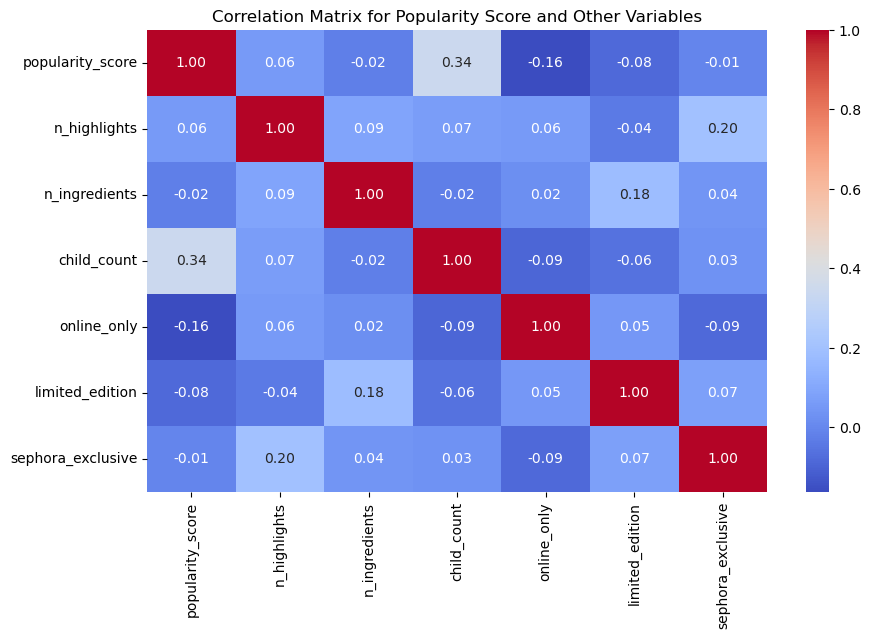

In [27]:
correlation_columns = ['popularity_score',  'n_highlights', 'n_ingredients', 'child_count', 'online_only', 'limited_edition', 'sephora_exclusive']


correlation_matrix = df[correlation_columns].corr()
print(correlation_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Popularity Score and Other Variables')
plt.show()


## 4.1 Ingredient combinations by category

We now look for bundles of ingredient families that consistently boost popularity_score within each primary_category. Instead of brute-forcing every has_* column across the catalog, we only consider the top 10 ingredient groups (per category) that delivered the strongest uplift in Section 3.3. This keeps the search focused on signals that actually matter for that segment.

We reuse those curated ingredient pools to build pair/triple combinations (minimum 5 products) via itertools.combinations. For each category we report the top five combos per size, along with their support and average popularity. This approach highlights the ingredient mixes that are both common enough and materially impactful inside that category.

In [28]:
from itertools import combinations

TOP_FEATURES_PER_CATEGORY = 10
MIN_COMBO_SUPPORT = 5
COMBO_SIZES = (2, 3)

def get_category_feature_pools(effect_df, feature_col):
    """Return mapping primary_category -> top N feature columns present in df."""
    pools = {}
    if effect_df is None or effect_df.empty:
        return pools
    for category, sub_df in effect_df.groupby("primary_category"):
        ordered = sub_df.sort_values("uplift_pct", ascending=False)[feature_col].tolist()
        pool = [col for col in ordered if col in df.columns][:TOP_FEATURES_PER_CATEGORY]
        if pool:
            pools[category] = pool
    return pools

def evaluate_category_combos(frame, columns):
    """Build combo stats for the provided dataframe subset and feature columns."""
    records = []
    for size in COMBO_SIZES:
        if len(columns) < size:
            continue
        for combo in combinations(columns, size):
            mask = frame[list(combo)].all(axis=1)
            support = int(mask.sum())
            if support < MIN_COMBO_SUPPORT:
                continue
            avg_popularity = frame.loc[mask, "popularity_score"].mean()
            records.append({
                "combo_size": size,
                "combination": " + ".join(combo),
                "products": support,
                "avg_popularity": round(avg_popularity, 3),
            })
    return records

In [29]:
ingredient_effect_df = globals().get("ingredient_effect_df")
ingredient_category_effect_df = globals().get("ingredient_category_effect_df")

if "primary_category" not in df.columns:
    print("primary_category column missing; cannot compute category-specific ingredient combos.")
else:
    ingredient_category_pools = get_category_feature_pools(
        ingredient_category_effect_df,
        feature_col="group",
    )

    if not ingredient_category_pools:
        print("Category-level ingredient drivers unavailable; falling back to global top uplift groups.")
        fallback_cols = []
        if ingredient_effect_df is not None and not ingredient_effect_df.empty:
            fallback_cols = ingredient_effect_df.sort_values("uplift_pct", ascending=False)["group"].tolist()
        else:
            fallback_cols = [col for col in df.columns if col.startswith("has_")] 
        ingredient_category_pools = {
            "All": [col for col in fallback_cols if col in df.columns][:TOP_FEATURES_PER_CATEGORY]
        }

    ingredient_combo_rows = []
    for category, subset in df.groupby("primary_category"):
        candidate_cols = ingredient_category_pools.get(category, [])
        if len(candidate_cols) < 2:
            continue
        combo_records = evaluate_category_combos(subset, candidate_cols)
        for record in combo_records:
            record["primary_category"] = category
        ingredient_combo_rows.extend(combo_records)

    ingredient_combo_df = pd.DataFrame(ingredient_combo_rows)

    if ingredient_combo_df.empty:
        print("No ingredient combinations met the support threshold. Try lowering MIN_COMBO_SUPPORT or reviewing the pools.")
    else:
        ingredient_combo_df = (
            ingredient_combo_df
            .sort_values(["primary_category", "combo_size", "avg_popularity"], ascending=[True, True, False])
            .groupby(["primary_category", "combo_size"])
            .head(5)
            .reset_index(drop=True)
        )

In [30]:
if 'ingredient_combo_df' in globals() and not ingredient_combo_df.empty:
    top_pairs = ingredient_combo_df[ingredient_combo_df["combo_size"] == 2]
    if top_pairs.empty:
        print("No ingredient pairs passed the filters.")
    else:
        display(top_pairs)
else:
    print("Ingredient combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
0,2,has_antioxidant_vitamins + has_silicones,63,0.019,Bath & Body
1,2,has_fatty_alcohols + has_antioxidant_vitamins,111,0.018,Bath & Body
2,2,has_fatty_alcohols + has_silicones,70,0.018,Bath & Body
3,2,has_niacinamide + has_humectants,25,0.018,Bath & Body
4,2,has_fatty_alcohols + has_emollient_oils,121,0.017,Bath & Body
10,2,has_chemical_sunscreen + has_emollient_oils,28,0.030,Fragrance
11,2,has_fragrance + has_emollient_oils,40,0.025,Fragrance
12,2,has_drying_alcohols + has_emollient_oils,42,0.024,Fragrance
13,2,has_fragrance_allergens + has_emollient_oils,44,0.023,Fragrance
14,2,has_drying_alcohols + has_chemical_sunscreen,555,0.018,Fragrance


In [31]:
if 'ingredient_combo_df' in globals() and not ingredient_combo_df.empty:
    top_triples = ingredient_combo_df[ingredient_combo_df["combo_size"] == 3]
    if top_triples.empty:
        print("No ingredient triplets passed the filters.")
    else:
        display(top_triples)
else:
    print("Ingredient combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
5,3,has_fatty_alcohols + has_antioxidant_vitamins ...,50,0.023,Bath & Body
6,3,has_antioxidant_vitamins + has_humectants + ha...,58,0.021,Bath & Body
7,3,has_antioxidant_vitamins + has_silicones + has...,56,0.021,Bath & Body
8,3,has_antioxidant_vitamins + has_silicones + has...,54,0.021,Bath & Body
9,3,has_antioxidant_vitamins + has_silicones + has...,50,0.021,Bath & Body
15,3,has_drying_alcohols + has_chemical_sunscreen +...,28,0.030,Fragrance
16,3,has_fragrance_allergens + has_chemical_sunscre...,28,0.030,Fragrance
17,3,has_chemical_sunscreen + has_fragrance + has_e...,28,0.030,Fragrance
18,3,has_drying_alcohols + has_fragrance + has_emol...,38,0.026,Fragrance
19,3,has_drying_alcohols + has_fragrance_allergens ...,40,0.025,Fragrance


In [32]:
if 'ingredient_combo_df' in globals() and not ingredient_combo_df.empty:
    display(
        ingredient_combo_df
        .sort_values('avg_popularity', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )
else:
    print("Ingredient combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
0,3,has_chemical_sunscreen + has_mineral_sunscreen...,12,0.122,Makeup
1,3,has_chemical_sunscreen + has_silicones + has_m...,13,0.117,Makeup
2,3,has_chemical_sunscreen + has_silicones + has_d...,8,0.113,Makeup
3,3,has_chemical_sunscreen + has_mineral_sunscreen...,8,0.109,Makeup
4,3,has_chemical_sunscreen + has_silicones + has_h...,18,0.107,Makeup
5,2,has_chemical_sunscreen + has_humectants,20,0.097,Makeup
6,2,has_chemical_sunscreen + has_silicones,21,0.095,Makeup
7,2,has_chemical_sunscreen + has_mineral_sunscreen,19,0.091,Makeup
8,2,has_chemical_sunscreen + has_drying_alcohols,12,0.078,Makeup
9,2,has_chemical_sunscreen + has_common_preservatives,21,0.078,Makeup


## 4.2 Highlight combinations by category

We mirror the same methodology for highlight tags: per primary category we keep only the top 10 highlight dummies surfaced in Section 3.3, then evaluate the strongest pair/triple combinations that meet the support threshold. The output shows which highlight narratives tend to co-occur in a category’s most popular products.

In [33]:
highlight_effect_df = globals().get("highlight_effect_df")
highlight_category_effect_df = globals().get("highlight_category_effect_df")

if "primary_category" not in df.columns:
    print("primary_category column missing; cannot compute category-specific highlight combos.")
else:
    highlight_category_pools = get_category_feature_pools(
        highlight_category_effect_df,
        feature_col="feature",
    )

    if not highlight_category_pools:
        print("Category-level highlight drivers unavailable; falling back to global top uplift tags.")
        if highlight_effect_df is not None and not highlight_effect_df.empty:
            fallback_cols = highlight_effect_df.sort_values("uplift_pct", ascending=False)["feature"].tolist()
        else:
            fallback_cols = [col for col in df.columns if col.startswith("tag_")]
        highlight_category_pools = {
            "All": [col for col in fallback_cols if col in df.columns][:TOP_FEATURES_PER_CATEGORY]
        }

    highlight_combo_rows = []
    for category, subset in df.groupby("primary_category"):
        candidate_cols = highlight_category_pools.get(category, [])
        if len(candidate_cols) < 2:
            continue
        combo_records = evaluate_category_combos(subset, candidate_cols)
        for record in combo_records:
            record["primary_category"] = category
        highlight_combo_rows.extend(combo_records)

    highlight_combo_df = pd.DataFrame(highlight_combo_rows)


    if highlight_combo_df.empty:
        print("No highlight combinations met the support threshold. Try adjusting the pools or MIN_COMBO_SUPPORT.")
    else:
        highlight_combo_df = (
            highlight_combo_df
            .sort_values(["primary_category", "combo_size", "avg_popularity"], ascending=[True, True, False])
            .groupby(["primary_category", "combo_size"])
            .head(5)
            .reset_index(drop=True)
        )

In [34]:
if 'highlight_combo_df' in globals() and not highlight_combo_df.empty:
    top_pairs = highlight_combo_df[highlight_combo_df["combo_size"] == 2]
    if top_pairs.empty:
        print("No highlight pairs passed the filters.")
    else:
        display(top_pairs)
else:
    print("Highlight combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
0,2,tag_best_for_oily_combo_normal_skin + tag_good...,6,0.038,Bath & Body
1,2,tag_good_for_loss_of_firmness + tag_good_for_d...,16,0.034,Bath & Body
2,2,tag_hyaluronic_acid + tag_good_for_dullness_un...,5,0.032,Bath & Body
3,2,tag_good_for_dryness + tag_cruelty-free,39,0.021,Bath & Body
4,2,tag_fragrance_free + tag_good_for_dullness_une...,10,0.019,Bath & Body
10,2,tag_floral_scent + tag_layerable_scent,150,0.016,Fragrance
11,2,tag_layerable_scent + tag_unisex__genderless_s...,145,0.011,Fragrance
12,2,tag_floral_scent + tag_unisex__genderless_scent,49,0.009,Fragrance
13,2,tag_layerable_scent + tag_cruelty-free,80,0.009,Fragrance
14,2,tag_floral_scent + tag_long-wearing,7,0.008,Fragrance


In [35]:
if 'highlight_combo_df' in globals() and not highlight_combo_df.empty:
    top_triples = highlight_combo_df[highlight_combo_df["combo_size"] == 3]
    if top_triples.empty:
        print("No highlight triplets passed the filters.")
    else:
        display(top_triples)
else:
    print("Highlight combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
5,3,tag_cruelty-free + tag_fragrance_free + tag_go...,5,0.026,Bath & Body
6,3,tag_good_for_loss_of_firmness + tag_good_for_d...,5,0.016,Bath & Body
7,3,tag_good_for_dryness + tag_cruelty-free + tag_...,5,0.014,Bath & Body
8,3,tag_good_for_dryness + tag_cruelty-free + tag_...,5,0.009,Bath & Body
9,3,tag_good_for_dryness + tag_good_for_dullness_u...,6,0.009,Bath & Body
15,3,tag_floral_scent + tag_layerable_scent + tag_c...,17,0.010,Fragrance
16,3,tag_floral_scent + tag_layerable_scent + tag_u...,20,0.009,Fragrance
17,3,tag_floral_scent + tag_unisex__genderless_scen...,15,0.006,Fragrance
18,3,tag_layerable_scent + tag_unisex__genderless_s...,43,0.006,Fragrance
24,3,tag_clean_at_sephora + tag_good_for_damage + t...,49,0.029,Hair


In [36]:
if 'highlight_combo_df' in globals() and not highlight_combo_df.empty:
    display(
        highlight_combo_df
        .sort_values('avg_popularity', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )
else:
    print("Highlight combination analysis has not been computed yet.")

,combo_size,combination,products,avg_popularity,primary_category
0,2,tag_without_parabens + tag_without_silicones,5,0.129,Mini Size
1,3,tag_best_for_oily_combo_normal_skin + tag_long...,12,0.116,Makeup
2,2,tag_best_for_oily_combo_normal_skin + tag_with...,6,0.109,Makeup
3,3,tag_best_for_oily_combo_normal_skin + tag_with...,5,0.108,Makeup
4,2,tag_without_parabens + tag_long-wearing,5,0.102,Mini Size
5,2,tag_best_for_oily_combo_normal_skin + tag_long...,28,0.096,Makeup
6,2,tag_good_for_dryness + tag_best_for_dry_combo_...,5,0.091,Mini Size
7,2,tag_without_parabens + tag_good_for_dryness,9,0.087,Mini Size
8,2,tag_best_for_oily_combo_normal_skin + tag_long...,7,0.085,Mini Size
9,3,tag_best_for_oily_combo_normal_skin + tag_long...,6,0.085,Makeup


## 4.3 Going deeper, combining groups of ingredients with highlights 

Calculate average popularity score for combinations of ingredients and highlights

In [31]:
def get_popularity_by_ingredients_and_highlight(df, ingredients_list, highlight):
    filtered_df = df.copy()
    
    for ingredient in ingredients_list:
        filtered_df = filtered_df[filtered_df[ingredient] == 1]
    
    filtered_df = filtered_df[filtered_df[highlight] == 1]
    
    avg_popularity = filtered_df['popularity_score'].mean() if len(filtered_df) > 0 else 0
    return avg_popularity


In [32]:

combinations_3_ingredients_1_highlight = list(itertools.product(itertools.combinations(ingredient_columns, 3), highlight_columns))

popularity_3_ingredients_1_highlight = []

for combo in combinations_3_ingredients_1_highlight:
    ingredients_combo, highlight = combo
    avg_popularity = get_popularity_by_ingredients_and_highlight(df, ingredients_combo, highlight)
    popularity_3_ingredients_1_highlight.append(((ingredients_combo, highlight), avg_popularity))

popularity_3_ingredients_1_highlight_sorted = sorted(popularity_3_ingredients_1_highlight, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 3 Ingredients + 1 Highlight:")
for combo, score in popularity_3_ingredients_1_highlight_sorted[:10]:
    print(f"Combination: {combo}, Average Popularity Score: {score}")



Top 10 Combinations of 3 Ingredients + 1 Highlight:
Combination: (('has_drying_alcohols', 'has_silicones', 'has_chemical_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_humectants', 'has_chemical_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_natural_finish'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_common_preservatives'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_humectants', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.2309
Combination: (('has_chemical_sunsc

## 4.4 Brand and Popularity Interaction

We first compare the full distribution of popularity_score across the ten busiest brands. A boxplot makes it easy to see which brands consistently deliver higher-performing products versus those with only a few runaway hits.

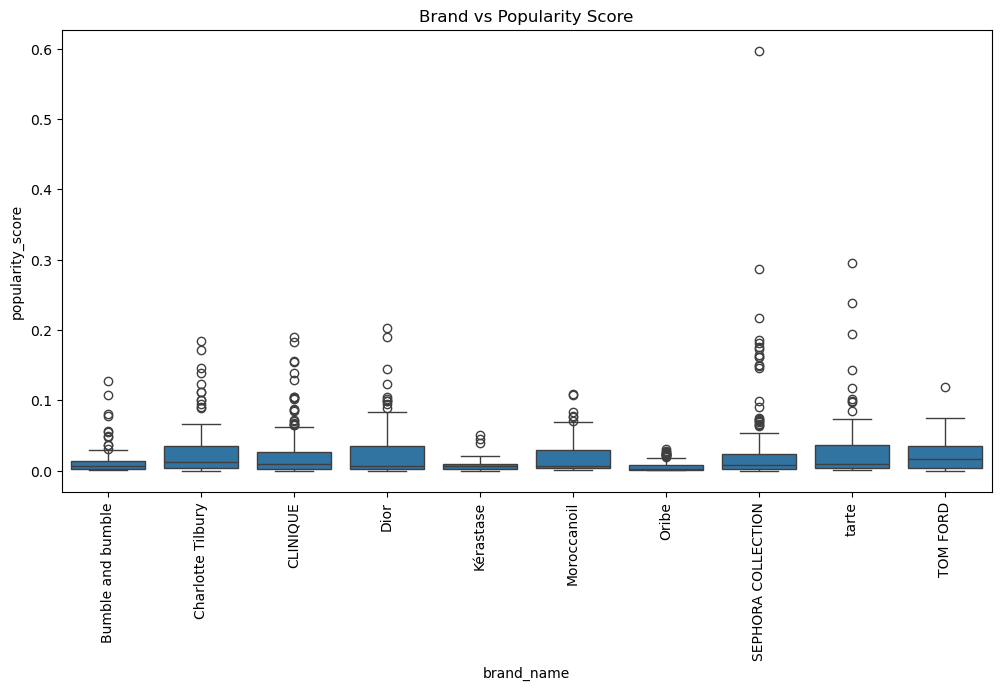

In [37]:
top_brands = df['brand_name'].value_counts().head(10).index
df_top_brands = df[df['brand_name'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand_name', y='popularity_score', data=df_top_brands)
plt.xticks(rotation=90)
plt.title('Brand vs Popularity Score')
plt.show()



Next, to spotlight individual products driving the extremes, we list the top ten products by popularity_score.

In [38]:

top_10_products = df.sort_values(by='popularity_score', ascending=False).head(10)
top_10_products[['product_name', 'popularity_score']]


,product_name,popularity_score
3745,Tattoo Liner Vegan Waterproof Liquid Eyeliner,0.8134
4644,Blush,0.8113
3915,Lip Sleeping Mask Intense Hydration with Vitam...,0.7760
2238,Pro Filt’r Soft Matte Longwear Liquid Foundation,0.7315
6881,24/7 Glide-On Waterproof Eyeliner Pencil,0.6926
6769,Better Than Sex Volumizing & Lengthening Mascara,0.6903
4643,Radiant Creamy Concealer,0.6829
2237,Gloss Bomb Universal Lip Luminizer,0.6325
5633,Cream Lip Stain Liquid Lipstick,0.5970
6771,Born This Way Natural Finish Longwear Liquid F...,0.5791


Finally, we collapse back to the brand level and rank brand_name by their mean popularity_score. This summarizes which brands deliver the strongest portfolios overall, complementing the distributional view and the single-product leaderboard.

In [39]:

brand_popularity_median = df.groupby('brand_name')['popularity_score'].mean()

top_brands_median = brand_popularity_median.sort_values(ascending=False).head(10)
print(top_brands_median)


brand_name
Buxom                         0.157057
stila                         0.092690
Urban Decay                   0.082516
Rosebud Perfume Co.           0.080867
NARS                          0.079487
Olaplex                       0.076743
KVD Beauty                    0.076357
K18 Biomimetic Hairscience    0.072850
belif                         0.072808
Fenty Beauty by Rihanna       0.072523
Name: popularity_score, dtype: float64


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_2003/2171375033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


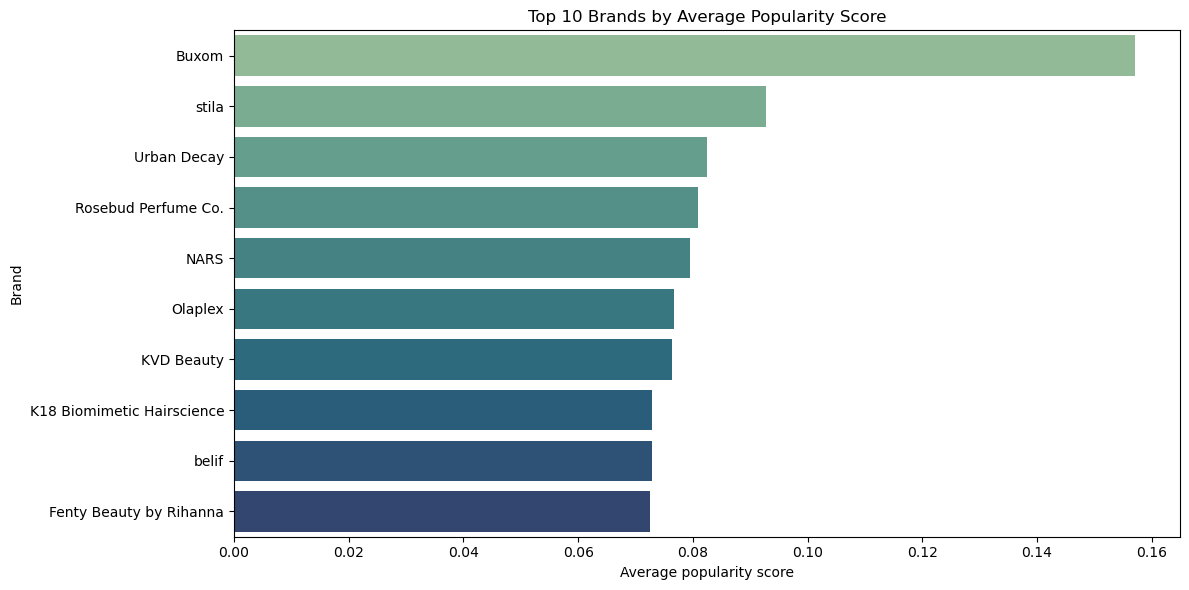

brand_name
Buxom                         0.157057
stila                         0.092690
Urban Decay                   0.082516
Rosebud Perfume Co.           0.080867
NARS                          0.079487
Olaplex                       0.076743
KVD Beauty                    0.076357
K18 Biomimetic Hairscience    0.072850
belif                         0.072808
Fenty Beauty by Rihanna       0.072523
Name: popularity_score, dtype: float64


In [40]:
brand_popularity_mean = df.groupby('brand_name')['popularity_score'].mean()

# Top 10 brands by average popularity score
top_brands_mean = brand_popularity_mean.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_brands_mean.values,
    y=top_brands_mean.index,
    palette='crest'
)
plt.title('Top 10 Brands by Average Popularity Score')
plt.xlabel('Average popularity score')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

print(top_brands_mean)

In [41]:
df.to_csv("data/products_final.csv", index=False)

# 5. Prediction Model

Definition of a clean target variable for our model which is `popularity_proxy`, the binary label defined above

In [42]:
MODEL_DATA_PATH = "data/products_final.csv"
model_df = pd.read_csv(MODEL_DATA_PATH)

target_col = "popularity_proxy"
assert target_col in model_df.columns

print("Dataset shape:", model_df.shape)
print(model_df[target_col].value_counts(normalize=True))

Dataset shape: (7322, 83)
popularity_proxy
0    0.699809
1    0.300191
Name: proportion, dtype: float64


## 5.2 Feature selection & preprocessing plan
We remove:
    Leakage features (loves, reviews, rating, etc.) that would not exist before launch for a new product.
    Metadata/text fields not useful for modeling.

We keep only pre-launch predictors:
    Numeric features (price, n_ingredients, n_highlights…)
    Binary ingredient/highlight flags (has_*, tag_*)
    Categorical features (brand, primary category)

This ensures a fair model that can predict popularity for new products.

In [43]:
leakage_cols = [
    "loves_count", "reviews", "rating",
    "log_loves", "log_reviews", "reviews_per_love",
    "loves_count_norm", "reviews_norm", "scaled_rating_norm",
    "scaled_rating"
]

exclude_cols = {
    "product_id", "product_name", "brand_id",
    "ingredients", "ingredients_list", "ingredients_text",
    "highlights", "highlights_list", "price_bucket", 
    "popularity_score", "popularity_proxy"
}

feature_candidates = [
    c for c in model_df.columns
    if c not in exclude_cols and c not in leakage_cols
]

binary_features = [
    c for c in feature_candidates
    if model_df[c].dropna().isin([0, 1]).all()
]

numeric_features = [
    c for c in feature_candidates
    if pd.api.types.is_numeric_dtype(model_df[c]) and c not in binary_features
]

categorical_features = [
    c for c in feature_candidates
    if not pd.api.types.is_numeric_dtype(model_df[c]) and c not in binary_features
]

print(f"Numeric features: {len(numeric_features)}")
print(f"Binary features: {len(binary_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: 4
Binary features: 53
Categorical features: 5


In [44]:
feature_candidates

['brand_name',
 'price_usd',
 'limited_edition',
 'new',
 'online_only',
 'out_of_stock',
 'sephora_exclusive',
 'primary_category',
 'secondary_category',
 'tertiary_category',
 'child_count',
 'n_highlights',
 'tag_vegan',
 'tag_cruelty-free',
 'tag_clean_at_sephora',
 'tag_without_parabens',
 'tag_good_for_dryness',
 'tag_hydrating',
 'tag_good_for_dullness_uneven_texture',
 'tag_without_sulfates_sls_and_sles',
 'tag_long-wearing',
 'tag_clean_+_planet_positive',
 'tag_all_hair_types',
 'tag_good_for_anti-aging',
 'tag_hyaluronic_acid',
 'tag_without_phthalates',
 'tag_fragrance_free',
 'tag_best_for_dry_combo_normal_skin',
 'tag_matte_finish',
 'tag_good_for_pores',
 'tag_good_for_loss_of_firmness',
 'tag_layerable_scent',
 'tag_increases_shine',
 'tag_best_for_oily_combo_normal_skin',
 'tag_good_for_frizz',
 'tag_natural_finish',
 'tag_without_silicones',
 'tag_unisex__genderless_scent',
 'tag_floral_scent',
 'tag_good_for_damage',
 'tag_gluten_free',
 'tag_vitamin_c',
 'has_fragr

## 5.3 Train/test split and Gradient Boosting pipeline
We split the data into training and testing sets with stratification.
A preprocessing pipeline standardizes numeric features, imputes missing values, and one-hot encodes categorical fields.
We train a GradientBoostingClassifier, a strong non-linear model suitable for mixed feature types.

In [45]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

binary_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("bin", binary_pipeline, binary_features),
    ("cat", categorical_pipeline, categorical_features),
])

X = model_df[numeric_features + binary_features + categorical_features]
y = model_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

gb_clf = GradientBoostingClassifier(random_state=42)

popularity_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", gb_clf)
])

popularity_model.fit(X_train, y_train)

print("Train accuracy:", popularity_model.score(X_train, y_train))
print("Test accuracy:", popularity_model.score(X_test, y_test))

Train accuracy: 0.7959024390243903
Test accuracy: 0.7947200728265817


## 5.4 Evaluation on hold-out data
We evaluate performance on unseen data using accuracy, precision, recall, F1-score, ROC-AUC, and a confusion matrix.
This tells us how well the model can identify popular products using only pre-launch information.

In [46]:
y_pred = popularity_model.predict(X_test)
y_proba = popularity_model.predict_proba(X_test)[:,1]

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
display(pd.DataFrame(cm,
         index=["Actual 0","Actual 1"],
         columns=["Pred 0","Pred 1"]))


Classification report:
              precision    recall  f1-score   support

           0      0.810     0.923     0.863      1537
           1      0.735     0.495     0.592       660

    accuracy                          0.795      2197
   macro avg      0.772     0.709     0.727      2197
weighted avg      0.787     0.795     0.781      2197

ROC-AUC: 0.84476548175312


,Pred 0,Pred 1
Actual 0,1419,118
Actual 1,333,327


## 5.5 Quick feature importance snapshot
Even without SHAP we can inspect the Gradient Boosting feature importances to see which engineered fields drive the proxy label the most.

In [47]:
preprocessor_step = popularity_model.named_steps["preprocess"]
model_step = popularity_model.named_steps["model"]

feature_names = preprocessor_step.get_feature_names_out()
importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": model_step.feature_importances_})
    .sort_values("importance", ascending=False)
    .head(15)
)
importance_df

,feature,importance
1,num__child_count,0.377210
6,bin__online_only,0.133541
0,num__price_usd,0.047484
340,cat__primary_category_Skincare,0.027129
5,bin__new,0.020951
335,cat__primary_category_Fragrance,0.020583
288,cat__brand_name_The Ordinary,0.018808
469,cat__tertiary_category_Mascara,0.016809
381,cat__secondary_category_Value & Gift Sets,0.016367
4,bin__limited_edition,0.014143


# 6. Explainability


Train SHAP Explainer & Compute SHAP Values. We initialize the SHAP and create a TreeExplained for the GradientBoostClassifier. We compute the shap_values for the X_test set. 

In [48]:
import shap
shap.initjs()

# Access trained model and preprocessor
model_step = popularity_model.named_steps["model"]
preprocess_step = popularity_model.named_steps["preprocess"]

# Transform train/test into final numeric arrays
X_train_transformed = preprocess_step.transform(X_train)
X_test_transformed  = preprocess_step.transform(X_test)

# Convert to dense numpy array (SHAP requires numeric matrix)
if hasattr(X_train_transformed, "toarray"):
    X_train_array = X_train_transformed.toarray()
    X_test_array  = X_test_transformed.toarray()
else:
    X_train_array = X_train_transformed
    X_test_array  = X_test_transformed

# Get feature names after transformation
feature_names = preprocess_step.get_feature_names_out()

In [49]:
X_train_dense = pd.DataFrame(X_train_array, columns=feature_names)
X_test_dense  = pd.DataFrame(X_test_array,  columns=feature_names)
explainer = shap.TreeExplainer(model_step)

# Compute SHAP values for the test set
shap_values = explainer(X_test_dense)
print("SHAP values shape:", shap_values.values.shape)

SHAP values shape: (2197, 495)


## 6.1 Global Explainebility plots 

Shows the global influence of each feature on popularity predictions.

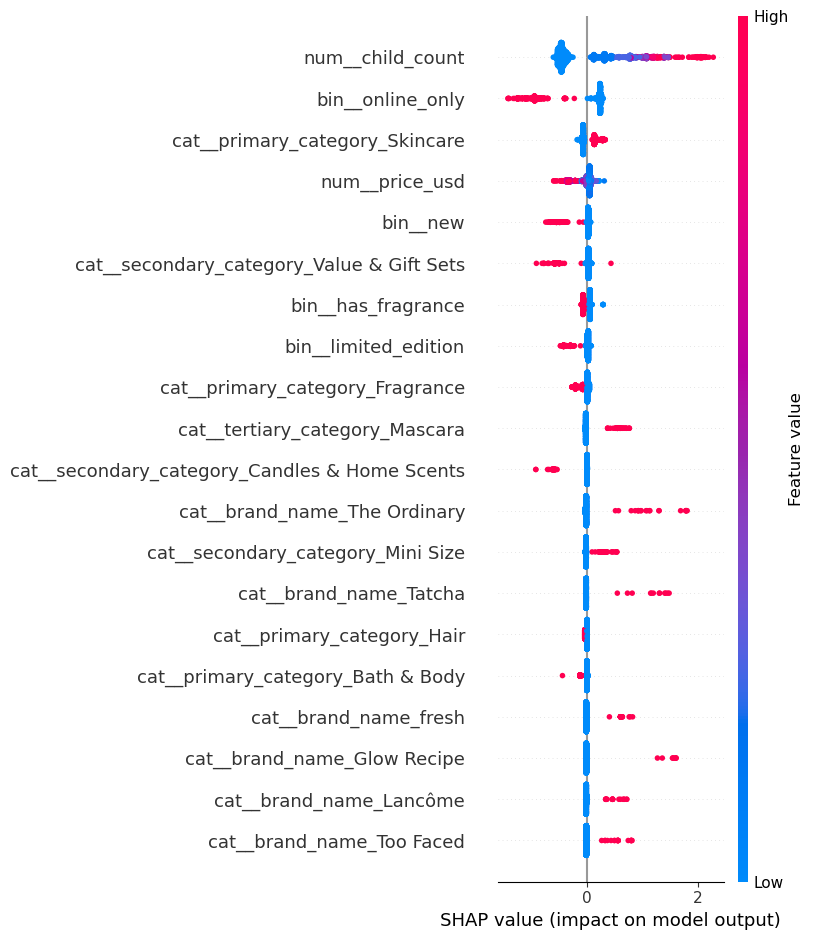

In [50]:
shap.summary_plot(shap_values.values, X_test_array, feature_names=feature_names)

Shows the SHAP bar summary producing the global top-10 feature importance chart based on the mean absolute SHAP magnitude

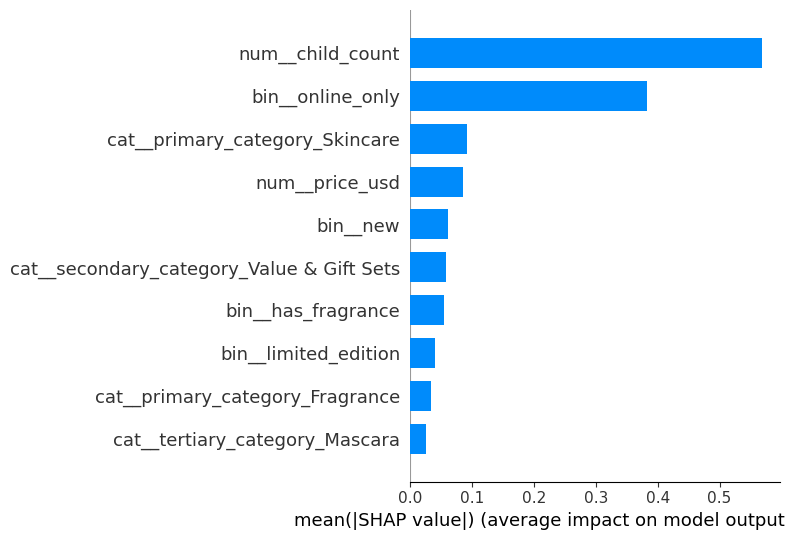

In [51]:
shap.summary_plot(shap_values.values, X_test_transformed,
                  feature_names=feature_names,
                  plot_type="bar", max_display=10
                  )

## 6.2 Local explainability 

We print two waterfall plots: 
- **first one**: we select a product that it's true class is popular
- **second one** we select a product that it's true class is unpopular

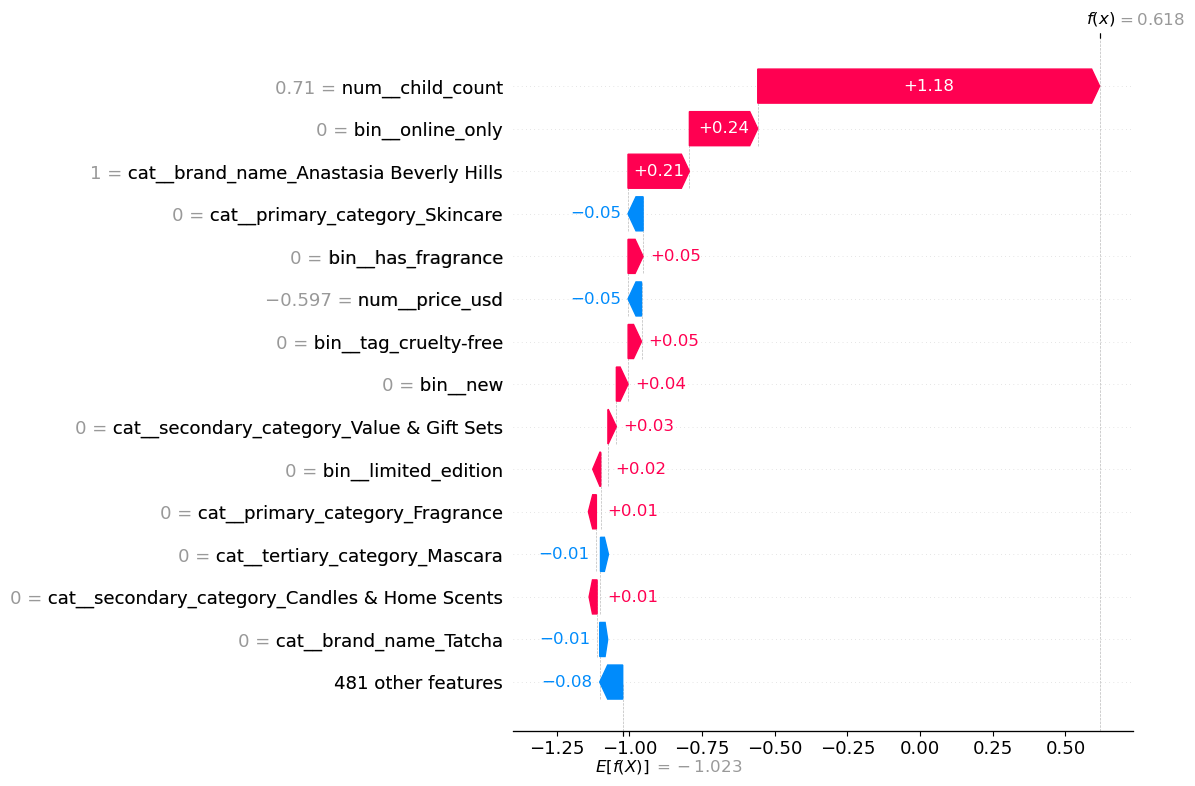

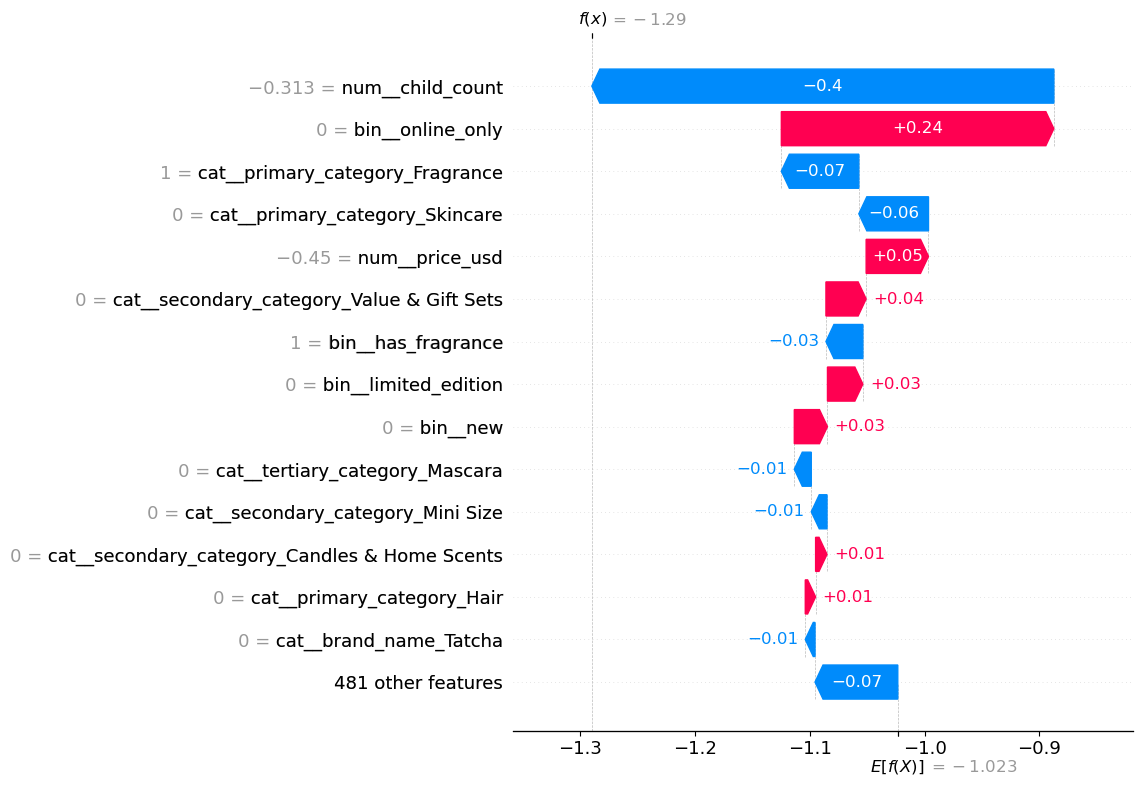

In [52]:
# 1) Waterfall plot for the first POPULAR product (proxy=1)
idx_popular = y_test[y_test == 1].index[0]         # get index label
pos_in_test = list(X_test.index).index(idx_popular)  # convert to positional index

shap.plots.waterfall(shap_values[pos_in_test], max_display=15)

# 2) Waterfall plot for the first UNPOPULAR product (proxy=0)
idx_unpopular = y_test[y_test == 0].index[0]
pos_in_test = list(X_test.index).index(idx_unpopular)

shap.plots.waterfall(shap_values[pos_in_test], max_display=15)

## 6.3 Filtering SHAP values by category

In order to filter SHAP values by category, we will NOT re-train the model, we willl just compute SHAP for the whole test set (as we have done) and then filter by category. 

Also, some categories in the dataset have too few products in the test split to generate statistically meaningful SHAP interpretations.
SHAP requires a sufficient number of observations to estimate how each feature contributes to model predictions.
When a category has too few samples, the SHAP values become unstable, biased, and not interpretable, so we exclude them to preserve the reliability of insights.

In [53]:
primary_cats = model_df["primary_category"].unique()

shap_values_by_category = {}
X_test_transformed_by_category = {}

cat_series = model_df.loc[X_test.index, "primary_category"]

for cat in primary_cats:
    mask = (cat_series == cat).values
    n = mask.sum()

    if n < 100:   # threshold you want
        continue

    shap_values_by_category[cat] = shap_values.values[mask]
    X_test_transformed_by_category[cat] = X_test_array[mask]



===== SHAP for category: Fragrance =====



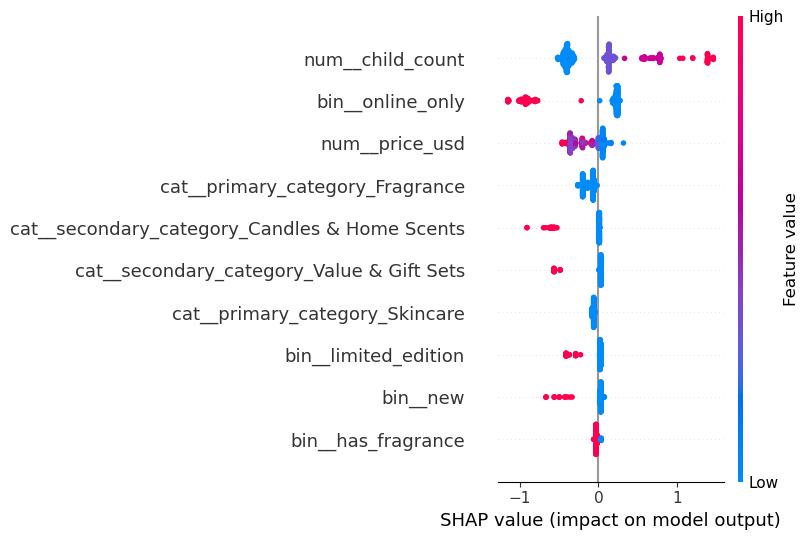


===== SHAP for category: Bath & Body =====



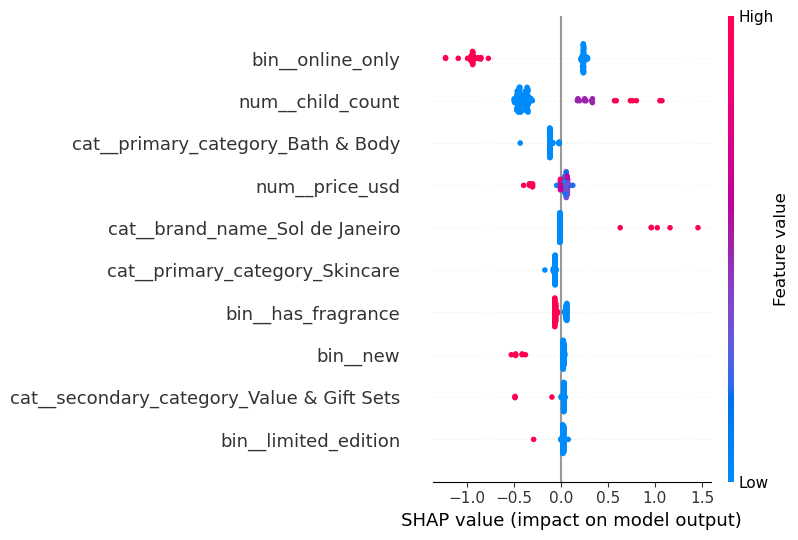


===== SHAP for category: Mini Size =====

Skipping Mini Size (only 71 samples)

===== SHAP for category: Hair =====



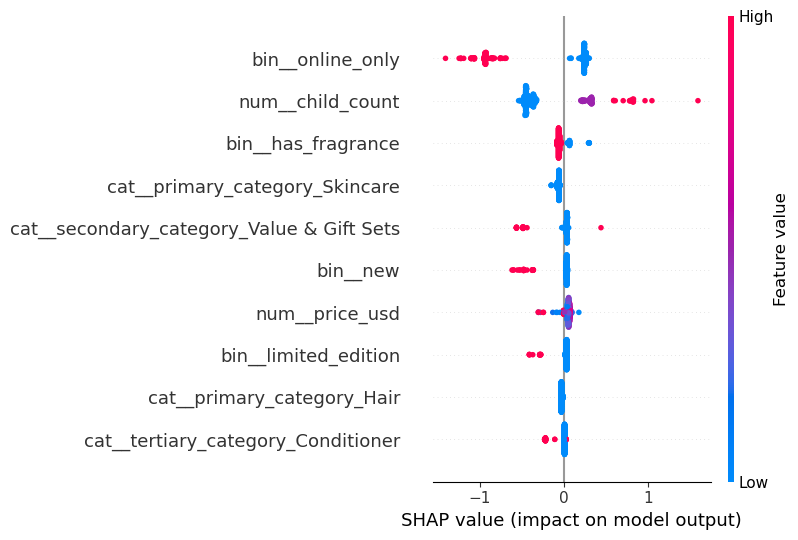


===== SHAP for category: Makeup =====



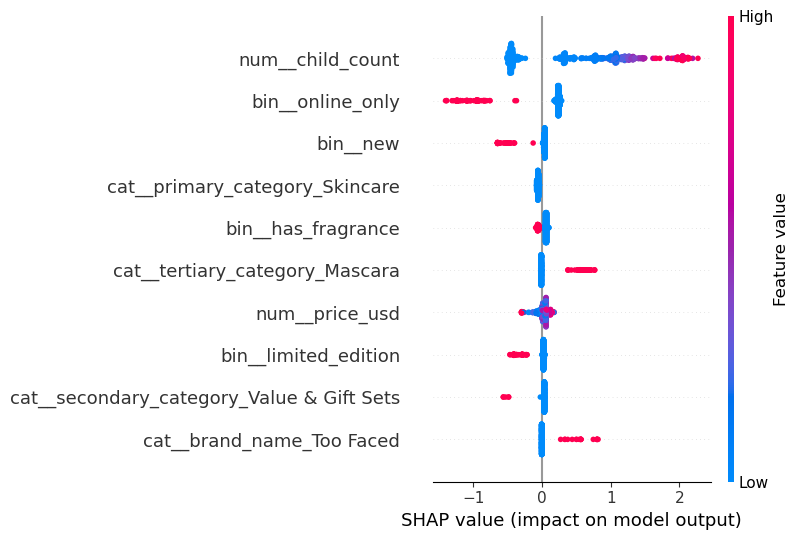


===== SHAP for category: Skincare =====



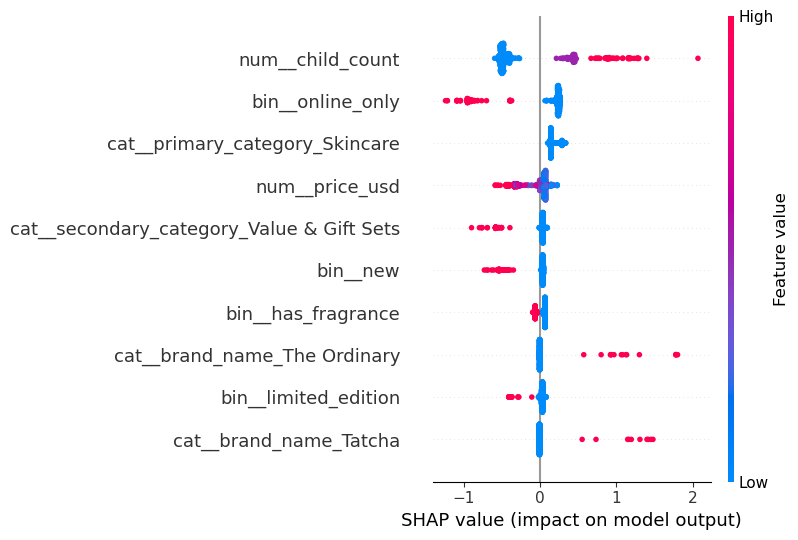


===== SHAP for category: Men =====

Skipping Men (only 15 samples)

===== SHAP for category: Tools & Brushes =====

Skipping Tools & Brushes (only 0 samples)


In [54]:
primary_cats = model_df["primary_category"].unique()

for cat in primary_cats:
    print(f"\n===== SHAP for category: {cat} =====\n")

    # mask rows in X_test that belong to this category
    mask = (model_df.loc[X_test.index, "primary_category"] == cat).values
    
    n = mask.sum()
    if n < 100:
        print(f"Skipping {cat} (only {n} samples)")
        continue

    # filtered SHAP summary plot
    shap.summary_plot(
        shap_values.values[mask],     # same shape subset
        X_test_array[mask],           # transformed numeric data subset
        feature_names=feature_names,
        max_display=10
    )

In [57]:
bundle = {
    "model": popularity_model,
    "explainer": explainer,
    "shap_values": shap_values,  
    "feature_names": feature_names,
    "X_test_transformed": X_test_array,  
    "shap_values_by_category": shap_values_by_category,
    "X_test_transformed_by_category": X_test_transformed_by_category,
}
Path("models").mkdir(exist_ok=True)
joblib.dump(bundle, "models/popularity_bundle.pkl")

['models/popularity_bundle.pkl']